In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import lsst.sims.maf.utils as utils
from astropy.table import Table, Column
import json
from scipy.optimize import curve_fit

In [2]:
# Establish where the LSST simulations data is coming from, and where output data will go
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [3]:
# Establish points of evaluation, how to evaluate (slice) them, and any constraints
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
# slicer = slicers.UserPointsSlicer(ra,dec)
slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,size=1000),np.random.uniform(-60,-30,size=1000))
sql = ''
# Run the metric, slicer, and constraint together as a "bundle"
bundle = metricBundles.MetricBundle(metric,slicer,sql)
# Group the previous bundle with the data from the LSST simulations
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
%time bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 33.4 s, sys: 1.93 s, total: 35.4 s
Wall time: 40.5 s


In [4]:
def survey_setup(bundle):
    opsimlist = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for key in ['fieldRA', 'fieldDec', 
                                                                  'expMJD', 'filter', 'fiveSigmaDepth']}
        opsim = Table(bdict)
        opsim.sort(['expMJD'])
        opsim = opsim['fieldRA', 'fieldDec', 'expMJD','filter','fiveSigmaDepth']
    
        # Only do the following if you need to narrow simulation filters to those matching your lightcurve data
        opsim = opsim[opsim['filter'] != 'u']
        opsim = opsim[opsim['filter'] != 'y']
        opsimlist.append(opsim)
    return opsimlist

In [5]:
def tde_model(asciifile):
    model = np.genfromtxt(asciifile, dtype=[('mjd',np.float), ('filter','S1'), ('mag',np.float)])
    model = Table(model)
    model = model[model['mjd'] <= 200]
    filter_match = np.where(model['filter'] == 'g')
    peakmag = model['mag'][filter_match].min()
    model['mag'] = model['mag'] - peakmag
    filter_match = np.where(model['filter'] == 'g')
    peakmag_row = model['mag'][filter_match].argmin()
    peakday = model['mjd'][filter_match][peakmag_row]
    model['mjd'] = model['mjd'] - peakday
    model = model['mjd', 'filter', 'mag']
    return model

In [6]:
def tde_raw(jsonfile):
    # Open and load json file with TDE values
    tde_data = open(jsonfile)
    tde = json.load(tde_data)
    z = 0.1696
    # Set up dictionary for json data
    data = {'mjd': [], 'filter': [], 'mag': [], 'magerror': [], 'upperlimit': []}
    # Use for loop to call to values within the json file
    for entry in tde['PS1-10jh']['photometry']:
        # Ignore instances in which 'band' and 'magnitude' have no data
        if 'band' in entry and 'magnitude' in entry:
            data['mjd'].append(float(entry['time']))
            data['filter'].append(entry['band'])
            data['mag'].append(float(entry['magnitude']))
            # Ignore instances in which 'upperlimit' has no value (i.e. is 'false')
            if 'upperlimit' in entry:
                data['upperlimit'].append(entry['upperlimit'])
            else:
                data['upperlimit'].append(False)
            # Ignore instances in which 'e_magnitude' has no value (i.e. upperlimit IS the error)
            if 'e_magnitude' in entry:
                data['magerror'].append(float(entry['e_magnitude']))
            else:
                data['magerror'].append(99)
    
    # Table the now-full dictionary of TDE data
    tde_table = Table(data)
    
    # Update the table to modify the data for magnitude errors no more than 0.3, no upperlimit values,
    # mjd in terms of obvservation day number, and filters in only g, r, i, and z.
    tde_table = tde_table[tde_table['upperlimit'] == False]
    tde_table['mjd'] = tde_table['mjd'] - tde_table['mjd'].min()
    tde_table['rfday'] = tde_table['mjd']/(1+z)
    tde_table = tde_table[tde_table['magerror'] <= 0.3]
    tde_table = tde_table[tde_table['filter'] != 'NUV']
    tde_table = tde_table[tde_table['filter'] != 'F225W']
    tde_table = tde_table[tde_table['rfday'] <= 150]
    return tde_table

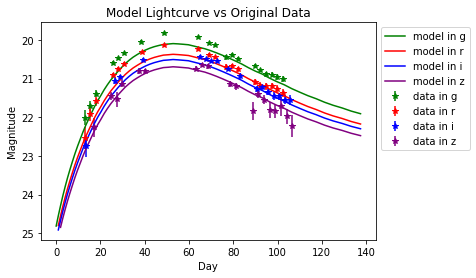

In [81]:
model = tde_model('G14_model_PS1-10jh.ascii')
colors = {'g':'green','r':'red','i':'blue','z':'purple'}
tde_table = tde_raw('PS1-10jh.json')
for f in ['g', 'r', 'i', 'z']:
    filter_match = np.where(model['filter'] == f)
    filter_match2 = np.where(tde_table['filter'] == f)
    plt.plot(model['mjd'][filter_match], model['mag'][filter_match], 
             color=colors[f], label=('model in %s' %f))
    plt.errorbar(tde_table['rfday'][filter_match2], tde_table['mag'][filter_match2], 
                 yerr=tde_table['magerror'][filter_match2], color=colors[f], fmt='*', label=('data in %s' %f))
plt.ylim(plt.ylim()[::-1])
plt.title('Model Lightcurve vs Original Data')
plt.xlabel('Day')
plt.ylabel('Magnitude')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [7]:
def find_peak(model):
    peak = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(model['filter'] == f)
        peakmag = model['mag'][filter_match].min()
        peakmag_row = model['mag'][filter_match].argmin()
        peakday = model['mjd'][filter_match][peakmag_row]
        peak[f] = {'peakday': peakday, 'peakmag': peakmag}
    return peak

In [8]:
def shift_peak(model, outputmag, outputtime):
    """
    Shifts peak magnitude and time of peak of a template lightcurve.
    """
    adjusted_tde = model.copy()
    adjusted_tde['mag'] += outputmag
    adjusted_tde['mjd'] += outputtime
    return adjusted_tde

In [9]:
def interpolate_lc(tde_table, time_range):
    lc = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(tde_table['filter'] == f)
        lc[f] = np.interp(time_range, tde_table['mjd'][filter_match], tde_table['mag'][filter_match],
                          left=99, right=99)
    return lc

In [10]:
def resample_lc(opsim, shifted_tde_table):
    time_range = opsim['expMJD']
    lc = interpolate_lc(shifted_tde_table, time_range)
    tde_lc = Table(lc)
    tde_lc['mjd'] = time_range
    tde_lc = tde_lc['mjd', 'g', 'r', 'i', 'z']
    return tde_lc

In [11]:
def update_opsim(opsim, tde_lc):    
    opsim['magnitude'] = 0.0
    for row in range(len(opsim)):
        f = opsim['filter'][row]
        opsim['magnitude'][row] = tde_lc[f][row]
    return opsim

In [12]:
def find_error(opsim):
    # Find error based off of 5sigDepth, and add it to the table with magnitudes
    snr = 5*(10**((-0.4)*(opsim['magnitude'] - opsim['fiveSigmaDepth'])))
    tde_err = 2.5/(snr*np.log(10))
    opsim['tde_err'] = tde_err
    opsim = opsim[opsim['tde_err'] < 0.3]
    return opsim

In [13]:
def add_noise(opsim):
    opsim['magnitude'] = np.random.normal(opsim['magnitude'], opsim['tde_err'])
    return opsim

In [14]:
def interpolate_lc_alltimes(shifted_tde_fmatch):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    lc = interpolate_lc(shifted_tde_fmatch, time_range)
    lc = Table(lc)
    lc['mjd'] = time_range
    tde_lc_all = Table()
    tde_lc_all.add_column(Column(name = 'mjd'))
    tde_lc_all.add_column(Column(name = 'filter'))
    tde_lc_all.add_column(Column(name = 'mag'))
    tde_lc_all = Table(names = ('mjd', 'filter', 'mag'), dtype = ('float', 'str', 'float'))
    for day in lc['mjd']:
        for f in ['g', 'r', 'i', 'z']:
            row = np.where(lc['mjd'] == day)
            tde_lc_all.add_row([day, f, lc[f][row]])
    return shifted_tde_all

In [15]:
def poly(x, a, b, c, d, e, f, g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

def curvefit_full_lightcurve(shifted_tde_all):
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(shifted_tde_all['filter'] == f)
        popt, pcov = curve_fit(poly, shifted_tde_all['mjd'][filter_match],
                               shifted_tde_all['mag'][filter_match], )
        plt.figure()
        plt.plot(shifted_tde_all['mjd'][filter_match], shifted_tde_all['mag'][filter_match], 
                 color = colors[f], label = '%s raw lightcurve' % f)
        plt.plot(shifted_tde_all['mjd'][filter_match], poly(shifted_tde_all['mjd'][filter_match], *popt), 
                 'black', label = '%s curvefit lightcurve' % f)
        plt.ylim(plt.ylim()[::-1])
        plt.title('TDE \'Curvefit\' and TDE interpolated over all times')
        plt.xlabel('Day')
        plt.ylabel('Magnitude')
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [25]:
def make_template_per_filter(f):
    def make_template(time, time_shift, mag_shift):
        new_model = model.copy()
        new_model['mjd'] += time_shift
        new_model['mag'] += mag_shift
        template = interpolate_lc(new_model, time)
        return template[f]
    return make_template

def poly2(x, a, b, c, x0):
    return a*(x-x0)**2 + b*(x-x0) + c

def find_resampled_peak(opsim_fmatch):
    opsim_peakmag = opsim_fmatch['magnitude'].min()
    opsim_peakday_row = opsim_fmatch['magnitude'].argmin()
    opsim_peakday = opsim_fmatch['expMJD'][opsim_peakday_row]
    return [opsim_peakday, opsim_peakmag]

def find_a(opsim_fmatch):
    time = opsim_fmatch.copy()
    time = time[time['expMJD'] <= (75 + shifted_tde_table['mjd'].min())]
    opsim_peakday, opsim_peakmag = find_resampled_peak(time)
    first_day = time['expMJD'].min()
    first_mag_row = time['expMJD'].argmin()
    first_mag = time['magnitude'][first_mag_row]
    last_day = time['expMJD'].max()
    last_mag_row = time['expMJD'].argmax()
    last_mag = time['magnitude'][last_mag_row]
    if first_day != opsim_peakday:
        A = (first_mag - opsim_peakmag)/((first_day - opsim_peakday)**2)
    else:
        A = (last_mag - opsim_peakmag)/((last_day - opsim_peakday)**2)
    return A

def curvefit_template(opsim_fmatch, f):
    popt1, pcov1 = curve_fit(make_template_per_filter(f), opsim_fmatch['expMJD'], opsim_fmatch['magnitude'], 
                             p0 = find_resampled_peak(opsim_fmatch), sigma = opsim_fmatch['tde_err'])
    return [popt1, pcov1]

def curvefit_poly(opsim_fmatch, shifted_tde_table, f):
    opsim_peakday, opsim_peakmag = find_resampled_peak(opsim_fmatch)
    A = find_a(opsim_fmatch)
    params = [A, 0, opsim_peakmag, opsim_peakday]
    time = opsim_fmatch.copy()
    time = time[time['expMJD'] <= (75 + shifted_tde_table['mjd'].min())]
    popt2, pcov2 = curve_fit(poly2, time['expMJD'], time['magnitude'], 
                             p0 = params, sigma = time['tde_err'])
    return [popt2, pcov2]

def plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt1, popt2):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    plt.figure()
    plt.errorbar(opsim_fmatch['expMJD'], opsim_fmatch['magnitude'], 
                 yerr = opsim_fmatch['tde_err'], color = colors[f],
                 fmt = '*', label = '%s resampled lightcurve' % f)
    plt.plot(time_range, make_template_per_filter(f)(time_range, *popt1), 
             'black', label = '%s curvefit resampled lightcurve' %f)
    plt.plot(time_range, poly2(time_range, *popt2), 
             'teal', label = '%s curvefit resampled lightcurve' %f)
    plt.plot(shifted_tde_fmatch['mjd'], shifted_tde_fmatch['mag'], 
             color = colors[f], label = '%s raw lightcurve' % f)
    plt.ylim((plt.ylim()[0], 26)[::-1])
    plt.title('Original, resample, and curvefit in %s at ra=%f and dec=%f, peakmag=%d and peaktime=%d'
              % (f, ra, dec, testpeakmag, testpeakday))
    plt.xlabel('Day')
    plt.ylabel('Magnitude')
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [17]:
def find_template_mag_diff(opsim_fmatch, f, shifted_tde_fmatch, popt):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    original_peak_mag = shifted_tde_fmatch['mag'].min()
    curvefit_peak_mag = make_template_per_filter(f)(time_range, *popt).min()
    peak_diff_mag = curvefit_peak_mag - original_peak_mag
    return peak_diff_mag

In [18]:
def find_template_day_diff(opsim_fmatch, f, shifted_tde_fmatch, popt):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    original_peakday_row = shifted_tde_fmatch['mag'].argmin()
    original_peakday = shifted_tde_fmatch['mjd'][original_peakday_row]
    curvefit_peakday = make_template_per_filter(f)(time_range, *popt).argmin() + time_range.min()
    peak_diff_day = curvefit_peakday - original_peakday
    return peak_diff_day

In [19]:
def find_poly_mag_diff(opsim_fmatch, f, shifted_tde_fmatch, popt):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    original_peak_mag = shifted_tde_fmatch['mag'].min()
    curvefit_peak_mag = poly2(time_range, *popt).min()
    peak_diff_mag = curvefit_peak_mag - original_peak_mag
    return peak_diff_mag

In [20]:
def find_poly_day_diff(opsim_fmatch, f, shifted_tde_fmatch, popt):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    original_peakday_row = shifted_tde_fmatch['mag'].argmin()
    original_peakday = shifted_tde_fmatch['mjd'][original_peakday_row]
    curvefit_peakday = poly2(time_range, *popt).argmin() + time_range.min()
    peak_diff_day = curvefit_peakday - original_peakday
    return peak_diff_day

In [21]:
def make_peak_diff_dict(peak_diff_dict, ra, dec, f, peak_diff_day, peak_diff_mag):
    peak_diff_dict['ra'].append(ra)
    peak_diff_dict['dec'].append(dec)
    peak_diff_dict['filter'].append(f)
    peak_diff_dict['peak_diff_mag'].append(peak_diff_mag)
    peak_diff_dict['peak_diff_day'].append(peak_diff_day)
    return peak_diff_dict

In [22]:
# Setup input variables needed, and run in order of function introduction
peakmag = np.arange(17, 22, 1)
peaktime = np.arange(59945.25, 60310.5, 30)
colors = {'g':'green','r':'red','i':'blue','z':'purple'}
opsimlist = survey_setup(bundle)
asciifile = 'G14_model_PS1-10jh.ascii'
model = tde_model(asciifile)
#tde_table = tde_raw('PS1-10jh.json')
inputpeak = find_peak(model)
#curvefit_full_lightcurve(tde_lc_all)

In [26]:
undetected = 0.
detected = 0.

no_peak = 0.
peak = 0.
good_template_fit = 0.
bad_template_fit = 0.
good_poly_fit = 0.
bad_poly_fit = 0.

good_template_diff_dict = {'ra': [], 'dec': [], 'filter': [], 'peak_diff_mag': [], 'peak_diff_day': []}
bad_template_diff_dict = {'ra': [], 'dec': [], 'filter': [], 'peak_diff_mag': [], 'peak_diff_day': []}
good_poly_diff_dict = {'ra': [], 'dec': [], 'filter': [], 'peak_diff_mag': [], 'peak_diff_day': []}
bad_poly_diff_dict = {'ra': [], 'dec': [], 'filter': [], 'peak_diff_mag': [], 'peak_diff_day': []}

for coord in range(len(bundle.metricValues)):
    opsim = opsimlist[coord]
    good_temp_per = 0.
    bad_temp_per = 0.
    good_poly_per = 0.
    bad_poly_per = 0.
    for testpeakmag in peakmag:
        for testpeakday in peaktime:
            shifted_tde_table = shift_peak(model, testpeakmag, testpeakday)
            opsim2 = opsim.copy()
            opsim2 = opsim2[opsim2['expMJD'] > shifted_tde_table['mjd'].min()]
            opsim2 = opsim2[opsim2['expMJD'] < shifted_tde_table['mjd'].max()]
            if len(opsim2) == 0:
                undetected += 4
            else:
                tde_lc = resample_lc(opsim2, shifted_tde_table)
                opsim2 = update_opsim(opsim2, tde_lc)
                opsim2 = find_error(opsim2)
                if len(opsim2) == 0:
                    undetected += 4
                else:
                    opsim2 = add_noise(opsim2)
                    ra = np.degrees(round(opsim2['fieldRA'][0], 5))
                    dec = np.degrees(round(opsim2['fieldDec'][0], 5))
                    survey = opsim2.copy()
                    survey = survey[survey['expMJD'] <= (60 + shifted_tde_table['mjd'].min())]
                    for f in ['g', 'r', 'i', 'z']:
                        filter_match = np.where(survey['filter'] == f)
                        survey2 = survey[filter_match]
                        if len(np.unique(np.round(survey2['expMJD']))) >= 4:
                            detected += 1
                            peak += 1
                            filter_match2 = np.where(opsim2['filter'] == f)
                            opsim_fmatch = opsim2[filter_match2]
                            filter_match3 = np.where(shifted_tde_table['filter'] == f)
                            shifted_tde_fmatch = shifted_tde_table[filter_match3]
                            popt1, pcov1 = curvefit_template(opsim_fmatch, f)
                            popt2, pcov2 = curvefit_poly(opsim_fmatch, shifted_tde_table, f)
                            template_peak_diff_mag = find_template_mag_diff(opsim_fmatch, f, shifted_tde_fmatch, popt1)
                            template_peak_diff_day = find_template_day_diff(opsim_fmatch, f, shifted_tde_fmatch, popt1)
                            poly_peak_diff_mag = find_poly_mag_diff(opsim_fmatch, f, shifted_tde_fmatch, popt2)
                            poly_peak_diff_day = find_poly_day_diff(opsim_fmatch, f, shifted_tde_fmatch, popt2)
                            if abs(template_peak_diff_mag) >= 0.5 or abs(template_peak_diff_day) >= 5:
                                bad_template_diff_dict = make_peak_diff_dict(bad_template_diff_dict, ra, dec, 
                                                                             f, template_peak_diff_day, 
                                                                             template_peak_diff_mag)
                                bad_template_diff_table = Table(bad_template_diff_dict)
                                #plot = plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt1, popt2)
                                bad_template_fit += 1
                                bad_temp_per += 1
                            else:
                                good_template_diff_dict = make_peak_diff_dict(good_template_diff_dict, ra, dec, 
                                                                              f, template_peak_diff_day, 
                                                                              template_peak_diff_mag)
                                good_template_diff_table = Table(good_template_diff_dict)
                                #plot = plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt2, popt2)
                                good_template_fit += 1
                                good_temp_per += 1
                            if abs(poly_peak_diff_mag) >= 0.5 or abs(poly_peak_diff_day) >= 5:
                                bad_poly_diff_dict = make_peak_diff_dict(bad_poly_diff_dict, ra, dec, 
                                                                         f, poly_peak_diff_day, 
                                                                         poly_peak_diff_mag)
                                bad_poly_diff_table = Table(bad_poly_diff_dict)
                                #plot = plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt1, popt2)
                                bad_poly_fit += 1
                                bad_poly_per += 1
                            else:
                                good_poly_diff_dict = make_peak_diff_dict(good_poly_diff_dict, ra, dec, 
                                                                          f, poly_peak_diff_day, 
                                                                          poly_peak_diff_mag)
                                good_poly_diff_table = Table(good_poly_diff_dict)
                                #plot = plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt1, popt2)
                                good_poly_fit += 1
                                good_poly_per += 1
                            temp_perc_per_location = (good_temp_per/(good_temp_per + bad_temp_per))*100
                            poly_perc_per_location = (good_poly_per/(good_poly_per + bad_poly_per))*100
                            print('ra: %f, dec: %f, template: %r, poly: %r' %(ra, dec, temp_perc_per_location, 
                                                                              poly_perc_per_location))
                        else:
                            undetected += 1
                            no_peak += 1

percent_peak = (peak/(peak+no_peak))*100
percent_good_template_fit = (good_template_fit/(good_template_fit+bad_template_fit))*100
percent_good_poly_fit = (good_poly_fit/(good_poly_fit+bad_poly_fit))*100
percent_detected = (detected/(detected+undetected))*100
print('peak ratio = %r' %percent_peak)
print('good template fit ratio = %r' %percent_good_template_fit)
print('good poly fit ratio = %r' %percent_good_poly_fit)
print('detected ratio = %r' %percent_detected)

ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 73.952809, dec: -42.788488, template: 100.0, poly: 100.0
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 100.0
ra: 126.044985, dec: -3

/home/mnewsome/envs/lsst_maf/lsst4/Linux64/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


ra: 126.044985, dec: -30.452707, template: 100.0, poly: 80.0
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 83.33333333333334
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 85.71428571428571
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 87.5
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 88.88888888888889
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 90.0
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 81.81818181818183
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 83.33333333333334
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 84.61538461538461
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 85.71428571428571
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 86.66666666666667
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 87.5
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 88.23529411764706
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 88.88888888888889
ra: 126.044985, 

ra: 104.237639, dec: -41.413389, template: 100.0, poly: 100.0
ra: 104.237639, dec: -41.413389, template: 100.0, poly: 100.0
ra: 104.237639, dec: -41.413389, template: 100.0, poly: 100.0
ra: 104.237639, dec: -41.413389, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 100.0
ra: 200.659560, dec: -47.424290, template: 100.0, poly: 90.0
ra: 97.065926, dec: -59.242117, template: 100.0, poly: 100.0
ra: 97.065926, dec: -59.242117, template: 100.0, poly: 50.0
ra: 97.06592

ra: 99.612723, dec: -48.066575, template: 100.0, poly: 100.0
ra: 99.612723, dec: -48.066575, template: 100.0, poly: 100.0
ra: 99.612723, dec: -48.066575, template: 100.0, poly: 100.0
ra: 99.612723, dec: -48.066575, template: 100.0, poly: 100.0
ra: 99.612723, dec: -48.066575, template: 100.0, poly: 100.0
ra: 134.263492, dec: -42.489977, template: 100.0, poly: 100.0
ra: 134.263492, dec: -42.489977, template: 100.0, poly: 100.0
ra: 134.263492, dec: -42.489977, template: 100.0, poly: 100.0
ra: 134.263492, dec: -42.489977, template: 100.0, poly: 100.0
ra: 138.146427, dec: -42.689939, template: 100.0, poly: 100.0
ra: 138.146427, dec: -42.689939, template: 100.0, poly: 100.0
ra: 138.146427, dec: -42.689939, template: 100.0, poly: 100.0
ra: 134.263492, dec: -42.489977, template: 100.0, poly: 87.5
ra: 134.263492, dec: -42.489977, template: 100.0, poly: 88.88888888888889
ra: 134.263492, dec: -42.489977, template: 100.0, poly: 90.0
ra: 134.263492, dec: -42.489977, template: 100.0, poly: 90.909090

ra: 93.523901, dec: -54.543290, template: 100.0, poly: 80.0
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 83.33333333333334
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 71.42857142857143
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 75.0
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 77.77777777777779
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 80.0
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 81.81818181818183
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 83.33333333333334
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 76.92307692307693
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 78.57142857142857
ra: 93.523901, dec: -54.543290, template: 100.0, poly: 80.0
ra: 2.546224, dec: -53.470713, template: 100.0, poly: 100.0
ra: 2.546224, dec: -53.470713, template: 100.0, poly: 50.0
ra: 2.546224, dec: -53.470713, template: 100.0, poly: 66.66666666666666
ra: 2.546224, dec: -53.470713, template: 100.0, poly: 50.0

ra: 68.290840, dec: -40.006205, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 68.290840, dec: -40.006205, template: 100.0, poly: 100.0
ra: 68.290840, dec: -40.006205, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 68.290840, dec: -40.006205, template: 100.0, poly: 100.0
ra: 68.290840, dec: -40.006205, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.869268, template: 100.0, poly: 100.0
ra: 64.593543, dec: -39.

ra: 135.081676, dec: -58.380389, template: 100.0, poly: 52.94117647058824
ra: 135.081676, dec: -58.380389, template: 100.0, poly: 50.0
ra: 135.081676, dec: -58.380389, template: 100.0, poly: 52.63157894736842
ra: 132.472999, dec: -31.197552, template: 100.0, poly: 100.0
ra: 132.472999, dec: -31.197552, template: 100.0, poly: 100.0
ra: 132.472999, dec: -31.197552, template: 100.0, poly: 100.0
ra: 127.127303, dec: -33.448130, template: 100.0, poly: 100.0
ra: 127.127303, dec: -33.448130, template: 100.0, poly: 100.0
ra: 127.127303, dec: -33.448130, template: 100.0, poly: 66.66666666666666
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 75.0
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 80.0
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 83.33333333333334
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 71.42857142857143
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 75.0
ra: 126.044985, dec: -30.452707, template: 100.0, poly: 77.77777777777779
ra

ra: 2.207033, dec: -48.201220, template: 100.0, poly: 77.77777777777779
ra: 6.612506, dec: -48.075170, template: 100.0, poly: 80.0
ra: 6.612506, dec: -48.075170, template: 100.0, poly: 72.72727272727273
ra: 2.207033, dec: -48.201220, template: 100.0, poly: 75.0
ra: 2.207033, dec: -48.201220, template: 100.0, poly: 76.92307692307693
ra: 2.207033, dec: -48.201220, template: 100.0, poly: 78.57142857142857
ra: 6.612506, dec: -48.075170, template: 100.0, poly: 80.0
ra: 6.612506, dec: -48.075170, template: 100.0, poly: 75.0
ra: 2.207033, dec: -48.201220, template: 100.0, poly: 76.47058823529412
ra: 2.207033, dec: -48.201220, template: 100.0, poly: 77.77777777777779
ra: 2.207033, dec: -48.201220, template: 100.0, poly: 78.94736842105263
ra: 6.612506, dec: -48.075170, template: 100.0, poly: 80.0
ra: 6.612506, dec: -48.075170, template: 100.0, poly: 76.19047619047619
ra: 6.612506, dec: -48.075170, template: 100.0, poly: 72.72727272727273
ra: 6.612506, dec: -48.075170, template: 100.0, poly: 69.

ra: 12.365002, dec: -45.019013, template: 100.0, poly: 75.0
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 76.92307692307693
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 78.57142857142857
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 73.33333333333333
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 75.0
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 70.58823529411765
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 72.22222222222221
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 73.68421052631578
ra: 99.136023, dec: -50.859745, template: 100.0, poly: 100.0
ra: 99.136023, dec: -50.859745, template: 100.0, poly: 100.0
ra: 99.136023, dec: -50.859745, template: 100.0, poly: 66.66666666666666
ra: 99.136023, dec: -50.859745, template: 100.0, poly: 75.0
ra: 99.136023, dec: -50.859745, template: 100.0, poly: 80.0
ra: 99.136023, dec: -50.859745, template: 100.0, poly: 83.33333333333334
ra: 99.136023, dec: -50.859745, template: 100.0, poly:

ra: 291.418367, dec: -34.460547, template: 100.0, poly: 70.27027027027027
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 68.42105263157895
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 69.23076923076923
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 70.0
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 68.29268292682927
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 66.66666666666666
ra: 294.824601, dec: -34.332777, template: 100.0, poly: 67.44186046511628
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 68.18181818181817
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 68.88888888888889
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 67.3913043478261
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 68.08510638297872
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 68.75
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 67.3469387755102
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 68.0
ra: 

ra: 306.693994, dec: -49.677160, template: 100.0, poly: 70.0
ra: 306.693994, dec: -49.677160, template: 100.0, poly: 63.63636363636363
ra: 306.693994, dec: -49.677160, template: 100.0, poly: 66.66666666666666
ra: 306.693994, dec: -49.677160, template: 100.0, poly: 61.53846153846154
ra: 306.693994, dec: -49.677160, template: 100.0, poly: 57.14285714285714
ra: 306.693994, dec: -49.677160, template: 100.0, poly: 60.0
ra: 204.918355, dec: -39.638939, template: 100.0, poly: 100.0
ra: 204.918355, dec: -39.638939, template: 100.0, poly: 100.0
ra: 204.918355, dec: -39.638939, template: 100.0, poly: 100.0
ra: 204.918355, dec: -39.638939, template: 100.0, poly: 100.0
ra: 204.918355, dec: -39.638939, template: 100.0, poly: 100.0
ra: 208.593307, dec: -39.869268, template: 100.0, poly: 100.0
ra: 204.918355, dec: -39.638939, template: 100.0, poly: 100.0
ra: 204.918355, dec: -39.638939, template: 100.0, poly: 100.0
ra: 204.918355, dec: -39.638939, template: 100.0, poly: 100.0
ra: 204.918355, dec: -39

ra: 74.206629, dec: -48.201220, template: 100.0, poly: 71.42857142857143
ra: 74.206629, dec: -48.201220, template: 100.0, poly: 75.0
ra: 74.206629, dec: -48.201220, template: 100.0, poly: 66.66666666666666
ra: 74.206629, dec: -48.201220, template: 100.0, poly: 70.0
ra: 74.206629, dec: -48.201220, template: 100.0, poly: 63.63636363636363
ra: 74.206629, dec: -48.201220, template: 100.0, poly: 66.66666666666666
ra: 74.206629, dec: -48.201220, template: 100.0, poly: 61.53846153846154
ra: 283.861626, dec: -45.469358, template: 100.0, poly: 100.0
ra: 283.861626, dec: -45.469358, template: 100.0, poly: 100.0
ra: 283.861626, dec: -45.469358, template: 100.0, poly: 100.0
ra: 285.793067, dec: -48.201220, template: 100.0, poly: 100.0
ra: 283.861626, dec: -45.469358, template: 100.0, poly: 100.0
ra: 285.793067, dec: -48.201220, template: 100.0, poly: 83.33333333333334
ra: 283.861626, dec: -45.469358, template: 100.0, poly: 85.71428571428571
ra: 283.861626, dec: -45.469358, template: 100.0, poly: 8

ra: 91.635432, dec: -46.879407, template: 100.0, poly: 76.92307692307693
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 71.42857142857143
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 73.33333333333333
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 75.0
ra: 95.867298, dec: -46.169512, template: 100.0, poly: 76.47058823529412
ra: 95.867298, dec: -46.169512, template: 100.0, poly: 72.22222222222221
ra: 95.867298, dec: -46.169512, template: 100.0, poly: 73.68421052631578
ra: 95.867298, dec: -46.169512, template: 100.0, poly: 70.0
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 71.42857142857143
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 72.72727272727273
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 73.91304347826086
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 75.0
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 72.0
ra: 91.635432, dec: -46.879407, template: 100.0, poly: 73.07692307692307
ra: 91.635432, dec: -46.879407

ra: 47.554924, dec: -43.366603, template: 100.0, poly: 75.0
ra: 48.133038, dec: -46.169512, template: 100.0, poly: 75.86206896551724
ra: 47.554924, dec: -43.366603, template: 100.0, poly: 76.66666666666667
ra: 47.554924, dec: -43.366603, template: 100.0, poly: 77.41935483870968
ra: 48.133038, dec: -46.169512, template: 100.0, poly: 78.125
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, template: 100.0, poly: 100.0
ra: 212.291176, dec: -40.006205, templa

ra: 140.581498, dec: -34.460547, template: 85.71428571428571, poly: 80.95238095238095
ra: 140.581498, dec: -34.460547, template: 86.36363636363636, poly: 81.81818181818183
ra: 140.581498, dec: -34.460547, template: 86.95652173913044, poly: 82.6086956521739
ra: 137.175263, dec: -34.332777, template: 87.5, poly: 83.33333333333334
ra: 140.581498, dec: -34.460547, template: 88.0, poly: 80.0
ra: 140.581498, dec: -34.460547, template: 88.46153846153845, poly: 80.76923076923077
ra: 140.581498, dec: -34.460547, template: 88.88888888888889, poly: 77.77777777777779
ra: 140.581498, dec: -34.460547, template: 85.71428571428571, poly: 75.0
ra: 140.581498, dec: -34.460547, template: 86.20689655172413, poly: 75.86206896551724
ra: 137.175263, dec: -34.332777, template: 86.66666666666667, poly: 76.66666666666667
ra: 140.581498, dec: -34.460547, template: 83.87096774193549, poly: 74.19354838709677
ra: 140.581498, dec: -34.460547, template: 84.375, poly: 75.0
ra: 140.581498, dec: -34.460547, template: 84

ra: 22.437027, dec: -51.758142, template: 100.0, poly: 81.81818181818183
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 83.33333333333334
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 84.61538461538461
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 85.71428571428571
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 86.66666666666667
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 87.5
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 88.23529411764706
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 83.33333333333334
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 84.21052631578947
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 85.0
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 85.71428571428571
ra: 22.437027, dec: -51.758142, template: 100.0, poly: 86.36363636363636
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 86.95652173913044
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 87.5
ra: 22.437027, de

ra: 12.343230, dec: -36.750659, template: 100.0, poly: 74.35897435897436
ra: 275.349765, dec: -52.971667, template: 100.0, poly: 100.0
ra: 275.349765, dec: -52.971667, template: 100.0, poly: 100.0
ra: 275.349765, dec: -52.971667, template: 100.0, poly: 100.0
ra: 270.401702, dec: -52.458870, template: 100.0, poly: 100.0
ra: 270.401702, dec: -52.458870, template: 100.0, poly: 80.0
ra: 275.349765, dec: -52.971667, template: 100.0, poly: 83.33333333333334
ra: 270.401702, dec: -52.458870, template: 100.0, poly: 71.42857142857143
ra: 270.401702, dec: -52.458870, template: 100.0, poly: 75.0
ra: 275.349765, dec: -52.971667, template: 100.0, poly: 77.77777777777779
ra: 275.349765, dec: -52.971667, template: 100.0, poly: 80.0
ra: 275.349765, dec: -52.971667, template: 100.0, poly: 81.81818181818183
ra: 270.401702, dec: -52.458870, template: 100.0, poly: 83.33333333333334
ra: 270.401702, dec: -52.458870, template: 100.0, poly: 76.92307692307693
ra: 275.349765, dec: -52.971667, template: 100.0, po

ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 282.681333, dec: -37.185534, template: 100.0, poly: 100.0
ra: 152.918425, dec: -58.380389, template: 100.0, poly: 100.0
ra: 152.918425, dec: -58.380389, template: 100.0, poly: 100.0
ra: 150.488511, dec: -61.010838, template: 100.0, poly: 66.66666666666666
ra: 152.918425, dec: -58.380389, template: 100.0, poly: 75.0
ra: 150.488511, dec: -61.010838, template: 100.0, poly: 80.0
ra: 150.488511, dec: -61.010838, template: 100.0, poly: 83.33333333333334
ra: 152.918425, dec: -58.380389, template: 100.0

ra: 0.000000, dec: -45.524362, template: 100.0, poly: 50.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 60.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 66.66666666666666
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 71.42857142857143
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 75.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 77.77777777777779
ra: 4.137901, dec: -45.469358, template: 100.0, poly: 80.0
ra: 4.137901, dec: -45.469358, template: 100.0, poly: 81.81818181818183
ra: 4.137901, dec: -45.469358, template: 100.0, poly: 83.33333333333334
ra: 4.137901, dec: -45.469358, template: 100.0, poly: 84.61538461538461
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 85.71428571428571
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 86.66666666666667
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 87.5
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 88.23529411764706
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 88.

ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.714941, dec: -28.778524, template: 100.0, poly: 100.0
ra: 116.

ra: 135.155587, dec: -37.011928, template: 100.0, poly: 100.0
ra: 135.155587, dec: -37.011928, template: 100.0, poly: 100.0
ra: 135.155587, dec: -37.011928, template: 100.0, poly: 100.0
ra: 184.594397, dec: -52.555127, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 184.594397, dec: -52.555127, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 184.594397, dec: -52.555127, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.

ra: 96.965085, dec: -40.550515, template: 100.0, poly: 81.25
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 82.35294117647058
ra: 96.965085, dec: -40.550515, template: 100.0, poly: 77.77777777777779
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 78.94736842105263
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 80.0
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 80.95238095238095
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 81.81818181818183
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 82.6086956521739
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 83.33333333333334
ra: 96.965085, dec: -40.550515, template: 100.0, poly: 84.0
ra: 96.965085, dec: -40.550515, template: 100.0, poly: 84.61538461538461
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 81.48148148148148
ra: 96.444840, dec: -43.366603, template: 100.0, poly: 82.14285714285714
ra: 96.965085, dec: -40.550515, template: 100.0, poly: 79.3103448275862
ra: 96.444840, dec

ra: 204.473167, dec: -31.197552, template: 100.0, poly: 75.0
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 80.0
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 66.66666666666666
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 71.42857142857143
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 75.0
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 77.77777777777779
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 80.0
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 81.81818181818183
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 83.33333333333334
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 84.61538461538461
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 78.57142857142857
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 80.0
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 81.25
ra: 204.473167, dec: -31.197552, template: 100.0, poly: 76.47058823529412
ra: 204.473167, dec: -31.197552, template

ra: 0.000000, dec: -34.502945, template: 93.75, poly: 50.0
ra: 0.000000, dec: -34.502945, template: 94.11764705882352, poly: 52.94117647058824
ra: 358.342129, dec: -31.706911, template: 94.44444444444444, poly: 50.0
ra: 0.000000, dec: -34.502945, template: 94.73684210526315, poly: 47.368421052631575
ra: 0.000000, dec: -34.502945, template: 95.0, poly: 50.0
ra: 0.000000, dec: -34.502945, template: 95.23809523809523, poly: 47.61904761904761
ra: 0.000000, dec: -34.502945, template: 95.45454545454545, poly: 50.0
ra: 0.000000, dec: -34.502945, template: 95.65217391304348, poly: 52.17391304347826
ra: 358.342129, dec: -31.706911, template: 95.83333333333334, poly: 50.0
ra: 0.000000, dec: -34.502945, template: 96.0, poly: 52.0
ra: 0.000000, dec: -34.502945, template: 96.15384615384616, poly: 53.84615384615385
ra: 0.000000, dec: -34.502945, template: 92.5925925925926, poly: 51.85185185185185
ra: 0.000000, dec: -34.502945, template: 92.85714285714286, poly: 53.57142857142857
ra: 0.000000, dec: -

ra: 49.388389, dec: -35.441450, template: 100.0, poly: 81.81818181818183
ra: 49.388389, dec: -35.441450, template: 100.0, poly: 83.33333333333334
ra: 49.388389, dec: -35.441450, template: 100.0, poly: 84.61538461538461
ra: 48.637814, dec: -32.459205, template: 100.0, poly: 78.57142857142857
ra: 48.637814, dec: -32.459205, template: 100.0, poly: 80.0
ra: 48.637814, dec: -32.459205, template: 100.0, poly: 81.25
ra: 48.637814, dec: -32.459205, template: 100.0, poly: 82.35294117647058
ra: 48.637814, dec: -32.459205, template: 100.0, poly: 83.33333333333334
ra: 48.637814, dec: -32.459205, template: 100.0, poly: 84.21052631578947
ra: 48.637814, dec: -32.459205, template: 100.0, poly: 85.0
ra: 49.388389, dec: -35.441450, template: 100.0, poly: 85.71428571428571
ra: 49.388389, dec: -35.441450, template: 100.0, poly: 81.81818181818183
ra: 49.388389, dec: -35.441450, template: 100.0, poly: 82.6086956521739
ra: 49.388389, dec: -35.441450, template: 100.0, poly: 83.33333333333334
ra: 48.637814, de

ra: 170.570109, dec: -53.656352, template: 100.0, poly: 60.0
ra: 170.570109, dec: -53.656352, template: 100.0, poly: 50.0
ra: 170.570109, dec: -53.656352, template: 100.0, poly: 57.14285714285714
ra: 170.570109, dec: -53.656352, template: 100.0, poly: 50.0
ra: 170.570109, dec: -53.656352, template: 100.0, poly: 55.55555555555556
ra: 354.146932, dec: -42.689939, template: 100.0, poly: 100.0
ra: 354.146932, dec: -42.689939, template: 100.0, poly: 100.0
ra: 354.146932, dec: -42.689939, template: 100.0, poly: 100.0
ra: 354.146932, dec: -42.689939, template: 100.0, poly: 100.0
ra: 354.146932, dec: -42.689939, template: 100.0, poly: 100.0
ra: 19.635837, dec: -46.879407, template: 100.0, poly: 100.0
ra: 19.635837, dec: -46.879407, template: 100.0, poly: 100.0
ra: 19.635837, dec: -46.879407, template: 100.0, poly: 100.0
ra: 19.635837, dec: -46.879407, template: 100.0, poly: 100.0
ra: 19.635837, dec: -46.879407, template: 100.0, poly: 100.0
ra: 19.635837, dec: -46.879407, template: 100.0, poly:

ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 100.0
ra: 107.

ra: 208.377875, dec: -53.306274, template: 100.0, poly: 42.857142857142854
ra: 208.377875, dec: -53.306274, template: 100.0, poly: 37.5
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 0.0
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 50.0
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 33.33333333333333
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 25.0
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 40.0
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 33.33333333333333
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 42.857142857142854
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 37.5
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 44.44444444444444
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 50.0
ra: 347.657039, dec: -36.750659, template: 100.0, poly: 54.54545454545454
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 100.0
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 100.0
ra: 40

ra: 145.657331, dec: -31.706911, template: 100.0, poly: 100.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 0.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 50.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 66.66666666666666
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 50.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 60.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 66.66666666666666
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 71.42857142857143
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 75.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 77.77777777777779
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 70.0
ra: 264.793018, dec: -48.966692, template: 100.0, poly: 100.0
ra: 265.563073, dec: -51.758142, template: 100.0, poly: 100.0
ra: 265.563073, dec: -51.758142, template: 100.0, poly: 100.0
ra: 264.793018, dec: -48.966692, template: 100.0, poly: 75.0
ra: 265.563073, dec: -51.75814

ra: 203.349597, dec: -52.971667, template: 100.0, poly: 75.0
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 60.0
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 66.66666666666666
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 71.42857142857143
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 62.5
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 66.66666666666666
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 70.0
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 63.63636363636363
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 66.66666666666666
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 61.53846153846154
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 57.14285714285714
ra: 203.349597, dec: -52.971667, template: 100.0, poly: 60.0
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 100.0
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 100.0
ra: 291.418367, dec: -34.460547, template: 100.0, pol

ra: 154.995397, dec: -47.819058, template: 100.0, poly: 86.20689655172413
ra: 29.284446, dec: -34.078957, template: 100.0, poly: 100.0
ra: 29.284446, dec: -34.078957, template: 100.0, poly: 50.0
ra: 29.284446, dec: -34.078957, template: 100.0, poly: 33.33333333333333
ra: 29.284446, dec: -34.078957, template: 100.0, poly: 25.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, poly: 100.0
ra: 131.634762, dec: -45.019013, template: 100.0, po

ra: 224.844682, dec: -37.011928, template: 100.0, poly: 66.66666666666666
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 60.0
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 54.54545454545454
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 58.333333333333336
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 61.53846153846154
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 57.14285714285714
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 53.333333333333336
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 56.25
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 58.82352941176471
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 55.55555555555556
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 52.63157894736842
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 55.00000000000001
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 57.14285714285714
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 54.54

ra: 161.598735, dec: -52.458870, template: 100.0, poly: 80.0
ra: 161.598735, dec: -52.458870, template: 100.0, poly: 66.66666666666666
ra: 166.436791, dec: -51.758142, template: 100.0, poly: 71.42857142857143
ra: 166.436791, dec: -51.758142, template: 100.0, poly: 75.0
ra: 161.598735, dec: -52.458870, template: 100.0, poly: 77.77777777777779
ra: 166.436791, dec: -51.758142, template: 100.0, poly: 80.0
ra: 166.436791, dec: -51.758142, template: 100.0, poly: 81.81818181818183
ra: 161.598735, dec: -52.458870, template: 100.0, poly: 83.33333333333334
ra: 166.436791, dec: -51.758142, template: 100.0, poly: 76.92307692307693
ra: 161.598735, dec: -52.458870, template: 100.0, poly: 71.42857142857143
ra: 166.436791, dec: -51.758142, template: 100.0, poly: 66.66666666666666
ra: 4.728048, dec: -50.801303, template: 100.0, poly: 0.0
ra: 4.728048, dec: -50.801303, template: 100.0, poly: 0.0
ra: 4.728048, dec: -50.801303, template: 100.0, poly: 33.33333333333333
ra: 4.728048, dec: -50.801303, templa

ra: 130.439572, dec: -33.824563, template: 100.0, poly: 84.61538461538461
ra: 130.439572, dec: -33.824563, template: 100.0, poly: 78.57142857142857
ra: 130.439572, dec: -33.824563, template: 100.0, poly: 80.0
ra: 130.439572, dec: -33.824563, template: 100.0, poly: 75.0
ra: 130.439572, dec: -33.824563, template: 100.0, poly: 76.47058823529412
ra: 9.736272, dec: -42.489977, template: 100.0, poly: 100.0
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 100.0
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 66.66666666666666
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 75.0
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 80.0
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 83.33333333333334
ra: 9.736272, dec: -42.489977, template: 100.0, poly: 85.71428571428571
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 87.5
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 77.77777777777779
ra: 12.365002, dec: -45.019013, template: 100.0, poly: 80.0
ra: 

ra: 305.418017, dec: -41.767477, template: 100.0, poly: 83.33333333333334
ra: 305.418017, dec: -41.767477, template: 100.0, poly: 80.0
ra: 305.418017, dec: -41.767477, template: 100.0, poly: 80.76923076923077
ra: 305.418017, dec: -41.767477, template: 100.0, poly: 81.48148148148148
ra: 305.418017, dec: -41.767477, template: 100.0, poly: 78.57142857142857
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -5

ra: 120.792681, dec: -48.966692, template: 100.0, poly: 66.66666666666666
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 69.23076923076923
ra: 120.132634, dec: -46.169512, template: 100.0, poly: 71.42857142857143
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 66.66666666666666
ra: 120.132634, dec: -46.169512, template: 100.0, poly: 62.5
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 64.70588235294117
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 61.111111111111114
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 63.1578947368421
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 60.0
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 61.904761904761905
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 63.63636363636363
ra: 120.132634, dec: -46.169512, template: 100.0, poly: 60.86956521739131
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 58.333333333333336
ra: 120.792681, dec: -48.966692, template: 100.0, poly: 60.0
r

ra: 193.388726, dec: -35.441450, template: 100.0, poly: 55.55555555555556
ra: 193.388726, dec: -35.441450, template: 100.0, poly: 57.89473684210527
ra: 193.388726, dec: -35.441450, template: 100.0, poly: 60.0
ra: 310.611307, dec: -35.441450, template: 100.0, poly: 100.0
ra: 310.611307, dec: -35.441450, template: 100.0, poly: 100.0
ra: 310.611307, dec: -35.441450, template: 100.0, poly: 66.66666666666666
ra: 310.611307, dec: -35.441450, template: 75.0, poly: 50.0
ra: 310.611307, dec: -35.441450, template: 80.0, poly: 60.0
ra: 310.611307, dec: -35.441450, template: 83.33333333333334, poly: 66.66666666666666
ra: 310.611307, dec: -35.441450, template: 85.71428571428571, poly: 71.42857142857143
ra: 310.611307, dec: -35.441450, template: 87.5, poly: 75.0
ra: 310.611307, dec: -35.441450, template: 88.88888888888889, poly: 77.77777777777779
ra: 310.611307, dec: -35.441450, template: 90.0, poly: 80.0
ra: 310.611307, dec: -35.441450, template: 90.9090909090909, poly: 72.72727272727273
ra: 310.61

ra: 129.273603, dec: -39.313499, template: 100.0, poly: 50.0
ra: 129.273603, dec: -39.313499, template: 100.0, poly: 66.66666666666666
ra: 129.273603, dec: -39.313499, template: 100.0, poly: 75.0
ra: 129.273603, dec: -39.313499, template: 100.0, poly: 60.0
ra: 129.273603, dec: -39.313499, template: 100.0, poly: 66.66666666666666
ra: 129.273603, dec: -39.313499, template: 100.0, poly: 71.42857142857143
ra: 129.273603, dec: -39.313499, template: 100.0, poly: 75.0
ra: 284.581834, dec: -34.460547, template: 100.0, poly: 100.0
ra: 284.581834, dec: -34.460547, template: 100.0, poly: 100.0
ra: 284.581834, dec: -34.460547, template: 100.0, poly: 100.0
ra: 284.581834, dec: -34.460547, template: 100.0, poly: 100.0
ra: 284.581834, dec: -34.460547, template: 100.0, poly: 100.0
ra: 284.581834, dec: -34.460547, template: 100.0, poly: 100.0
ra: 284.581834, dec: -34.460547, template: 100.0, poly: 100.0
ra: 284.581834, dec: -34.460547, template: 100.0, poly: 100.0
ra: 284.581834, dec: -34.460547, templ

ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 100.0
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 93.75
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 94.11764705882352
ra: 288.000101, dec: -34.502945, template: 100.0, poly: 94.44444444444444
ra: 288.000101, dec: -34.502945, template: 100

ra: 80.844345, dec: -37.011928, template: 100.0, poly: 82.75862068965517
ra: 175.887157, dec: -46.963059, template: 100.0, poly: 100.0
ra: 175.887157, dec: -46.963059, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100.0
ra: 175.887157, dec: -46.963059, template: 100.0, poly: 100.0
ra: 175.887157, dec: -46.963059, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100.0
ra: 175.887157, dec: -46.963059, template: 100.0, poly: 100.0
ra: 175.887157, dec: -46.963059, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100.0
ra: 176.075660, dec: -44.183067, template: 100.0, poly: 100

ra: 125.663395, dec: -38.889510, template: 100.0, poly: 90.0
ra: 126.581847, dec: -41.767477, template: 100.0, poly: 90.32258064516128
ra: 126.581847, dec: -41.767477, template: 100.0, poly: 90.625
ra: 125.663395, dec: -38.889510, template: 100.0, poly: 90.9090909090909
ra: 126.581847, dec: -41.767477, template: 100.0, poly: 91.17647058823529
ra: 126.581847, dec: -41.767477, template: 100.0, poly: 91.42857142857143
ra: 126.581847, dec: -41.767477, template: 100.0, poly: 88.88888888888889
ra: 126.581847, dec: -41.767477, template: 100.0, poly: 89.1891891891892
ra: 125.663395, dec: -38.889510, template: 100.0, poly: 89.47368421052632
ra: 125.663395, dec: -38.889510, template: 100.0, poly: 89.74358974358975
ra: 125.663395, dec: -38.889510, template: 100.0, poly: 90.0
ra: 126.581847, dec: -41.767477, template: 100.0, poly: 90.2439024390244
ra: 125.663395, dec: -38.889510, template: 100.0, poly: 90.47619047619048
ra: 126.581847, dec: -41.767477, template: 100.0, poly: 88.37209302325581
ra: 

ra: 40.908041, dec: -55.363193, template: 100.0, poly: 80.0
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 83.33333333333334
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 71.42857142857143
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 62.5
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 66.66666666666666
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 70.0
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 63.63636363636363
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 66.66666666666666
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 69.23076923076923
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 64.28571428571429
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 60.0
ra: 40.908041, dec: -55.363193, template: 100.0, poly: 56.25
ra: 40.908041, dec: -55.363193, template: 94.11764705882352, poly: 58.82352941176471
ra: 256.907973, dec: -55.363193, template: 100.0, poly: 100.0
ra: 256.907973, dec: -55.363193, template

ra: 122.475458, dec: -54.543290, template: 100.0, poly: 66.66666666666666
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 75.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 60.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 66.66666666666666
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 71.42857142857143
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 75.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 77.77777777777779
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 80.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 72.72727272727273
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 66.66666666666666
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra: 188.386804, dec: -48.066575, template: 100.0, poly: 100.0
ra: 188.386804, dec: -48.066575, template: 100.0, poly: 100.0
ra: 188.386804, dec: -48.066575, template: 100.0, poly: 100.0
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 100.0
ra

ra: 129.246101, dec: -57.958119, template: 100.0, poly: 45.45454545454545
ra: 129.246101, dec: -57.958119, template: 100.0, poly: 50.0
ra: 124.896205, dec: -60.072333, template: 100.0, poly: 46.15384615384615
ra: 124.896205, dec: -60.072333, template: 100.0, poly: 50.0
ra: 124.896205, dec: -60.072333, template: 100.0, poly: 46.666666666666664
ra: 124.896205, dec: -60.072333, template: 100.0, poly: 50.0
ra: 129.246101, dec: -57.958119, template: 100.0, poly: 47.05882352941176
ra: 129.246101, dec: -57.958119, template: 100.0, poly: 50.0
ra: 124.896205, dec: -60.072333, template: 100.0, poly: 47.368421052631575
ra: 124.896205, dec: -60.072333, template: 100.0, poly: 50.0
ra: 124.896205, dec: -60.072333, template: 100.0, poly: 47.61904761904761
ra: 124.896205, dec: -60.072333, template: 100.0, poly: 50.0
ra: 129.246101, dec: -57.958119, template: 100.0, poly: 47.82608695652174
ra: 129.246101, dec: -57.958119, template: 100.0, poly: 50.0
ra: 124.896205, dec: -60.072333, template: 100.0, pol

ra: 81.736440, dec: -42.489977, template: 100.0, poly: 60.0
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 66.66666666666666
ra: 85.593592, dec: -42.184591, template: 100.0, poly: 71.42857142857143
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 75.0
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 66.66666666666666
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 70.0
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 63.63636363636363
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 66.66666666666666
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 69.23076923076923
ra: 85.593592, dec: -42.184591, template: 100.0, poly: 71.42857142857143
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 73.33333333333333
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 68.75
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 70.58823529411765
ra: 81.736440, dec: -42.489977, template: 100.0, poly: 72.22222222222221
ra: 81.736440, dec: -42.48997

ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 96.42857142857143
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 96.55172413793103
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 96.66666666666667
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 96.7741935483871
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 96.875
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 93.93939393939394
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 94.11764705882352
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 94.28571428571428
ra: 82.208557, dec: -34.120210, template: 100.0, poly: 100.0
ra: 82.208557, dec: -34.120210, template: 100.0, poly: 100.0
ra: 82.208557, dec: -34.120210, template: 100.0, poly: 100.0
ra: 82.208557, dec: -34.120210, template: 100.0, po

ra: 154.208153, dec: -34.120210, template: 100.0, poly: 75.0
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 100.0
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 100.0
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 66.66666666666666
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 75.0
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 80.0
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 83.33333333333334
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 85.71428571428571
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 75.0
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 77.77777777777779
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 80.0
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 81.81818181818183
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 83.33333333333334
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 76.92307692307693
ra: 13.593424, dec: -42.184591, template: 100.0, poly: 78.57142857

ra: 101.284614, dec: -34.078957, template: 100.0, poly: 56.52173913043478
ra: 101.284614, dec: -34.078957, template: 100.0, poly: 58.333333333333336
ra: 101.284614, dec: -34.078957, template: 100.0, poly: 60.0
ra: 101.284614, dec: -34.078957, template: 100.0, poly: 57.692307692307686
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 248.782285, dec: -30.353012, template: 100.0, poly: 100.0
ra: 50.475863, dec: -54.543290, template: 100.0, poly: 100.0
ra: 50.475863, dec: -54.543290, te

ra: 281.387022, dec: -48.075170, template: 100.0, poly: 100.0
ra: 281.387022, dec: -48.075170, template: 100.0, poly: 90.0
ra: 281.387022, dec: -48.075170, template: 100.0, poly: 90.9090909090909
ra: 281.387022, dec: -48.075170, template: 100.0, poly: 91.66666666666666
ra: 281.387022, dec: -48.075170, template: 100.0, poly: 92.3076923076923
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 100.0
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 50.0
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 33.33333333333333
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 25.0
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 40.0
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 33.33333333333333
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 28.57142857142857
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 37.5
ra: 311.362455, dec: -32.459205, template: 100.0, poly: 33.33333333333333
ra: 311.362455, dec: -32.459205, template: 100.0, poly:

ra: 308.429484, dec: -57.316406, template: 100.0, poly: 100.0
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 100.0
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 100.0
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 100.0
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 100.0
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 100.0
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 100.0
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 100.0
ra: 196.364096, dec: -46.879407, template: 100.0, poly: 100.0
ra: 196.364096, dec: -46.879407, template: 100.0, poly: 100.0
ra: 197.306038, dec: -49.677160, template: 100.0, poly: 100.0
ra: 197.306038, dec: -49.677160, template: 100.0, poly: 100.0
ra: 196.364096, dec: -46.879407, template: 100.0, poly: 100.0
ra: 196.364096, dec: -46.879407, template: 100.0, poly: 100.0
ra: 196.364096, dec: -46.879407, template: 100.0, poly: 100.0
ra: 197.306038, dec: -49.677160, template: 100.0, poly: 100.0
ra: 197.

ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 95.45454545454545
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 95.65217391304348
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 95.83333333333334
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 96.0
ra: 187.015716, dec: -36.909941, template: 100.0, poly: 96.15384615384616
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 96.29629629629629
ra: 187.309

ra: 190.109688, dec: -56.451813, template: 100.0, poly: 0.0
ra: 190.109688, dec: -56.451813, template: 100.0, poly: 50.0
ra: 190.109688, dec: -56.451813, template: 100.0, poly: 33.33333333333333
ra: 190.109688, dec: -56.451813, template: 100.0, poly: 25.0
ra: 190.109688, dec: -56.451813, template: 100.0, poly: 20.0
ra: 190.109688, dec: -56.451813, template: 100.0, poly: 16.666666666666664
ra: 26.570345, dec: -53.655779, template: 100.0, poly: 100.0
ra: 26.570345, dec: -53.655779, template: 100.0, poly: 100.0
ra: 26.570345, dec: -53.655779, template: 100.0, poly: 100.0
ra: 26.570345, dec: -53.655779, template: 100.0, poly: 100.0
ra: 26.570345, dec: -53.655779, template: 100.0, poly: 100.0
ra: 353.572828, dec: -28.759617, template: 100.0, poly: 0.0
ra: 353.572828, dec: -28.759617, template: 100.0, poly: 50.0
ra: 353.572828, dec: -28.759617, template: 100.0, poly: 33.33333333333333
ra: 353.572828, dec: -28.759617, template: 100.0, poly: 50.0
ra: 353.572828, dec: -28.759617, template: 100.

ra: 30.712257, dec: -58.172978, template: 100.0, poly: 100.0
ra: 36.000084, dec: -56.872364, template: 100.0, poly: 100.0
ra: 30.712257, dec: -58.172978, template: 100.0, poly: 100.0
ra: 30.712257, dec: -58.172978, template: 100.0, poly: 100.0
ra: 36.000084, dec: -56.872364, template: 100.0, poly: 100.0
ra: 30.712257, dec: -58.172978, template: 100.0, poly: 100.0
ra: 36.000084, dec: -56.872364, template: 100.0, poly: 100.0
ra: 30.712257, dec: -58.172978, template: 100.0, poly: 100.0
ra: 30.712257, dec: -58.172978, template: 100.0, poly: 100.0
ra: 36.000084, dec: -56.872364, template: 100.0, poly: 100.0
ra: 30.712257, dec: -58.172978, template: 100.0, poly: 100.0
ra: 36.000084, dec: -56.872364, template: 100.0, poly: 100.0
ra: 30.712257, dec: -58.172978, template: 100.0, poly: 92.3076923076923
ra: 30.712257, dec: -58.172978, template: 100.0, poly: 92.85714285714286
ra: 36.000084, dec: -56.872364, template: 100.0, poly: 93.33333333333333
ra: 30.712257, dec: -58.172978, template: 100.0, p

ra: 27.613128, dec: -48.066575, template: 100.0, poly: 0.0
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 50.0
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 66.66666666666666
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 50.0
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 60.0
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 50.0
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 42.857142857142854
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 50.0
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 44.44444444444444
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 40.0
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 45.45454545454545
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 41.66666666666667
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 46.15384615384615
ra: 107.999680, dec: -34.591754, template: 100.0, poly: 100.0
ra: 107.999680, dec: -34.591754, template: 100.0, poly: 100.0
ra: 107.999680, de

ra: 133.004704, dec: -47.819058, template: 100.0, poly: 100.0
ra: 132.472999, dec: -31.197552, template: 100.0, poly: 100.0
ra: 132.472999, dec: -31.197552, template: 100.0, poly: 100.0
ra: 132.472999, dec: -31.197552, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 100.0
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 87.5
ra: 187.309071, dec: -39.707121, template: 100.0, poly: 88.88888888888889
ra: 179.999848, dec: -40.103608, template: 100.0, poly: 100.0
ra: 179.999848, dec: -40.103608, template: 100.0, poly: 100.0
ra: 179.999848, dec: -40.103608, template: 100.0, poly: 100

ra: 3.709329, dec: -40.006205, template: 100.0, poly: 100.0
ra: 3.709329, dec: -40.006205, template: 100.0, poly: 100.0
ra: 3.709329, dec: -40.006205, template: 100.0, poly: 100.0
ra: 3.709329, dec: -40.006205, template: 100.0, poly: 100.0
ra: 3.709329, dec: -40.006205, template: 100.0, poly: 88.88888888888889
ra: 3.709329, dec: -40.006205, template: 100.0, poly: 80.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 100.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 100.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 100.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 100.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 100.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 100.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 100.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 100.0
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 88.88888888888889
ra: 154.995397, dec: -47.819058, template: 100.0, poly: 90.

ra: 28.375162, dec: -42.492842, template: 100.0, poly: 100.0
ra: 28.375162, dec: -42.492842, template: 100.0, poly: 100.0
ra: 28.375162, dec: -42.492842, template: 100.0, poly: 100.0
ra: 28.375162, dec: -42.492842, template: 100.0, poly: 100.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 100.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 100.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 66.66666666666666
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 50.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 60.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 66.66666666666666
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 71.42857142857143
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 62.5
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 55.55555555555556
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 60.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 63.63636363636363
ra: 41.287912, dec: -58.17297

ra: 121.563309, dec: -51.758142, template: 100.0, poly: 75.0
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 80.0
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 83.33333333333334
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 85.71428571428571
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 75.0
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 77.77777777777779
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 80.0
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 81.81818181818183
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 75.0
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 76.92307692307693
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 78.57142857142857
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 80.0
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 81.25
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 76.47058823529412
ra: 201.904024, dec: -50.212302, template: 100.0, poly

ra: 153.736609, dec: -42.489977, template: 100.0, poly: 92.85714285714286
ra: 157.593187, dec: -42.184591, template: 100.0, poly: 93.10344827586206
ra: 153.736609, dec: -42.489977, template: 100.0, poly: 93.33333333333333
ra: 157.593187, dec: -42.184591, template: 100.0, poly: 90.32258064516128
ra: 153.736609, dec: -42.489977, template: 100.0, poly: 87.5
ra: 164.461806, dec: -44.065038, template: 100.0, poly: 100.0
ra: 164.461806, dec: -44.065038, template: 100.0, poly: 100.0
ra: 164.461806, dec: -44.065038, template: 100.0, poly: 100.0
ra: 83.081745, dec: -39.638939, template: 100.0, poly: 100.0
ra: 83.081745, dec: -39.638939, template: 100.0, poly: 100.0
ra: 83.081745, dec: -39.638939, template: 100.0, poly: 100.0
ra: 83.081745, dec: -39.638939, template: 100.0, poly: 100.0
ra: 83.081745, dec: -39.638939, template: 100.0, poly: 100.0
ra: 179.999848, dec: -54.054557, template: 100.0, poly: 100.0
ra: 179.999848, dec: -54.054557, template: 100.0, poly: 50.0
ra: 179.999848, dec: -54.0545

ra: 193.562905, dec: -51.758142, template: 100.0, poly: 75.0
ra: 193.562905, dec: -51.758142, template: 100.0, poly: 77.77777777777779
ra: 193.562905, dec: -51.758142, template: 100.0, poly: 70.0
ra: 193.562905, dec: -51.758142, template: 100.0, poly: 72.72727272727273
ra: 193.562905, dec: -51.758142, template: 100.0, poly: 75.0
ra: 193.562905, dec: -51.758142, template: 100.0, poly: 69.23076923076923
ra: 193.562905, dec: -51.758142, template: 100.0, poly: 64.28571428571429
ra: 193.562905, dec: -51.758142, template: 100.0, poly: 60.0
ra: 193.562905, dec: -51.758142, template: 100.0, poly: 62.5
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 0.0
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 50.0
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 33.33333333333333
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 25.0
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 20.0
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 16.666666666666664
ra: 305

ra: 51.570212, dec: -57.316406, template: 100.0, poly: 69.23076923076923
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 100.0
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 100.0
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 66.66666666666666
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 75.0
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 80.0
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 83.33333333333334
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 85.71428571428571
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 75.0
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 77.77777777777779
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 80.0
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 81.81818181818183
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 83.33333333333334
ra: 291.709429, dec: -40.006205, template: 100.0, poly: 76.92307692307693
ra: 291.709429, dec: -40.006205, template

ra: 118.934006, dec: -59.242117, template: 100.0, poly: 81.81818181818183
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 83.33333333333334
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 84.61538461538461
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 85.71428571428571
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 80.0
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 81.25
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 76.47058823529412
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 77.77777777777779
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 78.94736842105263
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 75.0
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 76.19047619047619
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 77.27272727272727
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 78.26086956521739
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 75.0
ra: 118.934006,

ra: 89.954947, dec: -30.452707, template: 100.0, poly: 80.0
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 83.33333333333334
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 85.71428571428571
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 87.5
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 88.88888888888889
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 90.0
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 90.9090909090909
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 91.66666666666666
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 92.3076923076923
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 85.71428571428571
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 86.66666666666667
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 87.5
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 88.23529411764706
ra: 89.954947, dec: -30.452707, template: 100.0, poly: 88.88888888888889
ra: 89.954947, dec: -30.452707, 

ra: 159.806523, dec: -36.402874, template: 100.0, poly: 100.0
ra: 159.806523, dec: -36.402874, template: 100.0, poly: 100.0
ra: 163.229373, dec: -35.966853, template: 100.0, poly: 100.0
ra: 159.806523, dec: -36.402874, template: 100.0, poly: 100.0
ra: 159.806523, dec: -36.402874, template: 100.0, poly: 100.0
ra: 163.229373, dec: -35.966853, template: 100.0, poly: 100.0
ra: 159.806523, dec: -36.402874, template: 100.0, poly: 100.0
ra: 159.806523, dec: -36.402874, template: 100.0, poly: 100.0
ra: 163.229373, dec: -35.966853, template: 100.0, poly: 88.88888888888889
ra: 159.806523, dec: -36.402874, template: 100.0, poly: 90.0
ra: 159.806523, dec: -36.402874, template: 100.0, poly: 81.81818181818183
ra: 163.229373, dec: -35.966853, template: 100.0, poly: 75.0
ra: 163.229373, dec: -35.966853, template: 100.0, poly: 69.23076923076923
ra: 159.806523, dec: -36.402874, template: 100.0, poly: 71.42857142857143
ra: 163.229373, dec: -35.966853, template: 100.0, poly: 66.66666666666666
ra: 0.000000

ra: 0.000000, dec: -45.524362, template: 100.0, poly: 78.0952380952381
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 78.30188679245283
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 78.50467289719626
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 100.0
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 100.0
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 100.0
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 100.0
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 100.0
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 100.0
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 100.0
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 100.0
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 88.88888888888889
ra: 75.708924, dec: -40.006205, template: 100.0, poly: 90.0
ra: 53.663800, dec: -38.889510, template: 100.0, poly: 0.0
ra: 53.663800, dec: -38.889510, template: 100.0, poly: 50.0
ra: 53.663800, dec: -38.889510, template: 100

ra: 98.535563, dec: -31.850151, template: 100.0, poly: 52.94117647058824
ra: 98.535563, dec: -31.850151, template: 100.0, poly: 50.0
ra: 98.535563, dec: -31.850151, template: 100.0, poly: 47.368421052631575
ra: 98.535563, dec: -31.850151, template: 100.0, poly: 50.0
ra: 98.535563, dec: -31.850151, template: 100.0, poly: 47.61904761904761
ra: 98.535563, dec: -31.850151, template: 100.0, poly: 45.45454545454545
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 100.0
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 50.0
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 66.66666666666666
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 50.0
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 60.0
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 50.0
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 57.14285714285714
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 50.0
ra: 195.858747, dec: -32.992056, template: 100.0, poly: 55.5555555555555

ra: 329.288012, dec: -58.172978, template: 100.0, poly: 0.0
ra: 324.000185, dec: -59.692462, template: 100.0, poly: 50.0
ra: 329.288012, dec: -58.172978, template: 100.0, poly: 33.33333333333333
ra: 324.000185, dec: -59.692462, template: 100.0, poly: 50.0
ra: 329.288012, dec: -58.172978, template: 100.0, poly: 60.0
ra: 324.000185, dec: -59.692462, template: 100.0, poly: 66.66666666666666
ra: 329.288012, dec: -58.172978, template: 100.0, poly: 71.42857142857143
ra: 324.000185, dec: -59.692462, template: 100.0, poly: 75.0
ra: 324.000185, dec: -59.692462, template: 100.0, poly: 77.77777777777779
ra: 324.000185, dec: -59.692462, template: 100.0, poly: 80.0
ra: 219.709261, dec: -40.006205, template: 100.0, poly: 100.0
ra: 219.709261, dec: -40.006205, template: 100.0, poly: 100.0
ra: 219.709261, dec: -40.006205, template: 100.0, poly: 100.0
ra: 219.709261, dec: -40.006205, template: 100.0, poly: 100.0
ra: 219.709261, dec: -40.006205, template: 100.0, poly: 100.0
ra: 219.709261, dec: -40.0062

ra: 224.844682, dec: -37.011928, template: 100.0, poly: 100.0
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 100.0
ra: 227.081509, dec: -39.638939, template: 100.0, poly: 100.0
ra: 227.081509, dec: -39.638939, template: 100.0, poly: 100.0
ra: 227.081509, dec: -39.638939, template: 100.0, poly: 100.0
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 100.0
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 100.0
ra: 227.081509, dec: -39.638939, template: 100.0, poly: 100.0
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 100.0
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 100.0
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 90.9090909090909
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 91.66666666666666
ra: 224.844682, dec: -37.011928, template: 100.0, poly: 92.3076923076923
ra: 227.081509, dec: -39.638939, template: 100.0, poly: 92.85714285714286
ra: 227.081509, dec: -39.638939, template: 100.0, poly: 93.33333333333333
ra: 227.0815

ra: 188.864078, dec: -50.859745, template: 100.0, poly: 97.05882352941177
ra: 192.792850, dec: -48.966692, template: 100.0, poly: 97.14285714285714
ra: 188.864078, dec: -50.859745, template: 100.0, poly: 97.22222222222221
ra: 316.375262, dec: -42.492842, template: 100.0, poly: 0.0
ra: 316.375262, dec: -42.492842, template: 100.0, poly: 0.0
ra: 316.375262, dec: -42.492842, template: 100.0, poly: 33.33333333333333
ra: 316.375262, dec: -42.492842, template: 100.0, poly: 25.0
ra: 316.375262, dec: -42.492842, template: 100.0, poly: 40.0
ra: 316.375262, dec: -42.492842, template: 100.0, poly: 33.33333333333333
ra: 316.375262, dec: -42.492842, template: 85.71428571428571, poly: 28.57142857142857
ra: 316.375262, dec: -42.492842, template: 87.5, poly: 25.0
ra: 316.375262, dec: -42.492842, template: 88.88888888888889, poly: 22.22222222222222
ra: 316.375262, dec: -42.492842, template: 90.0, poly: 20.0
ra: 78.824669, dec: -34.332777, template: 100.0, poly: 100.0
ra: 78.824669, dec: -34.332777, tem

ra: 201.245696, dec: -57.958119, template: 100.0, poly: 55.55555555555556
ra: 201.245696, dec: -57.958119, template: 100.0, poly: 50.0
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 100.0
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 100.0
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 100.0
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 100.0
ra: 111.373828, dec: -33.146754, template: 100.0, poly: 100.0
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 100.0
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 85.71428571428571
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 87.5
ra: 111.373828, dec: -33.146754, template: 100.0, poly: 88.88888888888889
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 90.0
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 90.9090909090909
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 91.66666666666666
ra: 111.217984, dec: -30.353012, template: 100.0, poly: 92.3076923076923
ra:

ra: 63.736398, dec: -45.302627, template: 100.0, poly: 100.0
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 75.0
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 80.0
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 83.33333333333334
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 85.71428571428571
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 75.0
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 77.77777777777779
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 80.0
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 81.81818181818183
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 75.0
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 76.92307692307693
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 78.57142857142857
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 80.0
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 75.0
ra: 63.736398, dec: -45.302627, template: 100.0, poly: 76.47058823529412
ra: 63.7

ra: 128.193577, dec: -36.402874, template: 100.0, poly: 100.0
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 75.0
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 80.0
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 66.66666666666666
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 71.42857142857143
ra: 127.127303, dec: -33.448130, template: 100.0, poly: 75.0
ra: 127.127303, dec: -33.448130, template: 100.0, poly: 77.77777777777779
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 80.0
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 72.72727272727273
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 75.0
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 69.23076923076923
ra: 128.193577, dec: -36.402874, template: 100.0, poly: 71.42857142857143
ra: 127.127303, dec: -33.448130, template: 100.0, poly: 73.33333333333333
ra: 127.127303, dec: -33.448130, template: 100.0, poly: 75.0
ra: 128.193577, dec: -36.402874, template: 100.0, poly

ra: 23.867130, dec: -46.169512, template: 100.0, poly: 100.0
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 100.0
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 100.0
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 100.0
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 80.0
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 83.33333333333334
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 85.71428571428571
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 75.0
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 77.77777777777779
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 70.0
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 72.72727272727273
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 75.0
ra: 23.867130, dec: -46.169512, template: 100.0, poly: 76.92307692307693
ra: 299.526865, dec: -31.197552, template: 100.0, poly: 100.0
ra: 299.526865, dec: -31.197552, template: 100.0, poly: 100.0
ra: 299.526865, dec: -31.19

ra: 53.305701, dec: -49.677160, template: 100.0, poly: 100.0
ra: 53.305701, dec: -49.677160, template: 100.0, poly: 100.0
ra: 53.305701, dec: -49.677160, template: 100.0, poly: 88.88888888888889
ra: 355.272221, dec: -50.801303, template: 100.0, poly: 100.0
ra: 357.793235, dec: -48.201220, template: 100.0, poly: 100.0
ra: 355.272221, dec: -50.801303, template: 100.0, poly: 100.0
ra: 357.793235, dec: -48.201220, template: 100.0, poly: 100.0
ra: 355.272221, dec: -50.801303, template: 100.0, poly: 100.0
ra: 357.793235, dec: -48.201220, template: 100.0, poly: 100.0
ra: 355.272221, dec: -50.801303, template: 100.0, poly: 100.0
ra: 357.793235, dec: -48.201220, template: 100.0, poly: 100.0
ra: 355.272221, dec: -50.801303, template: 100.0, poly: 100.0
ra: 357.793235, dec: -48.201220, template: 100.0, poly: 100.0
ra: 355.272221, dec: -50.801303, template: 100.0, poly: 100.0
ra: 355.272221, dec: -50.801303, template: 100.0, poly: 100.0
ra: 357.793235, dec: -48.201220, template: 100.0, poly: 100.0

ra: 36.000084, dec: -37.345389, template: 100.0, poly: 100.0
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 50.0
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 66.66666666666666
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 75.0
ra: 36.000084, dec: -40.103608, template: 100.0, poly: 80.0
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 83.33333333333334
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 71.42857142857143
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 75.0
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 77.77777777777779
ra: 36.000084, dec: -40.103608, template: 100.0, poly: 80.0
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 81.81818181818183
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 75.0
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 76.92307692307693
ra: 36.000084, dec: -37.345389, template: 100.0, poly: 78.57142857142857
ra: 36.000084, dec: -40.103608, template: 100.0, poly: 80.0
ra: 36.0

ra: 288.000101, dec: -45.524362, template: 100.0, poly: 100.0
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 100.0
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 100.0
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 100.0
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 100.0
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 100.0
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 83.33333333333334
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 85.71428571428571
ra: 171.136191, dec: -50.859745, template: 100.0, poly: 87.5
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 88.88888888888889
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 90.0
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 90.9090909090909
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 91.66666666666666
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 92.3076923076923
ra: 167.206846, dec: -48.966692, template: 100.0, poly: 92.85714

ra: 314.535495, dec: -31.850151, template: 100.0, poly: 50.0
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 66.66666666666666
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 75.0
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 60.0
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 66.66666666666666
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 71.42857142857143
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 62.5
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 66.66666666666666
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 70.0
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 63.63636363636363
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 66.66666666666666
ra: 314.535495, dec: -31.850151, template: 92.3076923076923, poly: 61.53846153846154
ra: 314.535495, dec: -31.850151, template: 85.71428571428571, poly: 57.14285714285714
ra: 314.535495, dec: -31.850151, template: 86.66666666666667, poly: 60.0
ra: 139

ra: 107.999680, dec: -51.242480, template: 100.0, poly: 82.75862068965517
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 83.33333333333334
ra: 107.999680, dec: -48.440717, template: 100.0, poly: 83.87096774193549
ra: 107.999680, dec: -48.440717, template: 100.0, poly: 84.375
ra: 107.999680, dec: -48.440717, template: 100.0, poly: 84.84848484848484
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 85.29411764705883
ra: 107.999680, dec: -48.440717, template: 100.0, poly: 85.71428571428571
ra: 107.999680, dec: -48.440717, template: 100.0, poly: 86.11111111111111
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 86.48648648648648
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 86.8421052631579
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 87.17948717948718
ra: 107.999680, dec: -48.440717, template: 100.0, poly: 87.5
ra: 107.999680, dec: -48.440717, template: 100.0, poly: 87.8048780487805
ra: 107.999680, dec: -51.242480, template: 100.0, poly: 88.09523

ra: 302.754337, dec: -57.958119, template: 100.0, poly: 87.5
ra: 302.754337, dec: -57.958119, template: 100.0, poly: 88.88888888888889
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 90.0
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 90.9090909090909
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 91.66666666666666
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 92.3076923076923
ra: 302.754337, dec: -57.958119, template: 100.0, poly: 85.71428571428571
ra: 302.754337, dec: -57.958119, template: 100.0, poly: 86.66666666666667
ra: 302.754337, dec: -57.958119, template: 100.0, poly: 87.5
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 88.23529411764706
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 88.88888888888889
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 89.47368421052632
ra: 308.429484, dec: -57.316406, template: 100.0, poly: 90.0
ra: 302.754337, dec: -57.958119, template: 100.0, poly: 85.71428571428571
ra: 302.754337, de

ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 112.594228, dec: -52.555127, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.740004, dec: -31.450799, template: 100.0, poly: 100.0
ra: 135.

ra: 220.727980, dec: -50.801303, template: 100.0, poly: 80.0
ra: 220.727980, dec: -50.801303, template: 100.0, poly: 83.33333333333334
ra: 220.727980, dec: -50.801303, template: 100.0, poly: 85.71428571428571
ra: 220.727980, dec: -50.801303, template: 100.0, poly: 87.5
ra: 225.433682, dec: -50.583579, template: 100.0, poly: 88.88888888888889
ra: 220.727980, dec: -50.801303, template: 100.0, poly: 80.0
ra: 220.727980, dec: -50.801303, template: 100.0, poly: 81.81818181818183
ra: 220.727980, dec: -50.801303, template: 100.0, poly: 83.33333333333334
ra: 220.727980, dec: -50.801303, template: 100.0, poly: 84.61538461538461
ra: 225.433682, dec: -50.583579, template: 100.0, poly: 78.57142857142857
ra: 220.727980, dec: -50.801303, template: 100.0, poly: 73.33333333333333
ra: 225.433682, dec: -50.583579, template: 100.0, poly: 75.0
ra: 225.433682, dec: -50.583579, template: 100.0, poly: 76.47058823529412
ra: 225.433682, dec: -50.583579, template: 100.0, poly: 77.77777777777779
ra: 225.433682, 

ra: 133.053978, dec: -55.697227, template: 100.0, poly: 75.0
ra: 133.053978, dec: -55.697227, template: 100.0, poly: 77.77777777777779
ra: 339.570313, dec: -57.316406, template: 100.0, poly: 100.0
ra: 339.570313, dec: -57.316406, template: 100.0, poly: 100.0
ra: 339.570313, dec: -57.316406, template: 100.0, poly: 100.0
ra: 339.570313, dec: -57.316406, template: 100.0, poly: 100.0
ra: 296.918189, dec: -58.380389, template: 100.0, poly: 100.0
ra: 296.918189, dec: -58.380389, template: 100.0, poly: 100.0
ra: 296.918189, dec: -58.380389, template: 100.0, poly: 100.0
ra: 296.918189, dec: -58.380389, template: 100.0, poly: 100.0
ra: 296.918189, dec: -58.380389, template: 100.0, poly: 100.0
ra: 279.736330, dec: -45.302627, template: 100.0, poly: 100.0
ra: 279.736330, dec: -45.302627, template: 100.0, poly: 100.0
ra: 279.736330, dec: -45.302627, template: 100.0, poly: 100.0
ra: 279.736330, dec: -45.302627, template: 100.0, poly: 100.0
ra: 279.736330, dec: -45.302627, template: 100.0, poly: 100

ra: 103.405704, dec: -52.555127, template: 100.0, poly: 81.81818181818183
ra: 103.092296, dec: -55.363193, template: 100.0, poly: 75.0
ra: 103.405704, dec: -52.555127, template: 100.0, poly: 76.92307692307693
ra: 103.092296, dec: -55.363193, template: 100.0, poly: 78.57142857142857
ra: 103.092296, dec: -55.363193, template: 100.0, poly: 80.0
ra: 103.405704, dec: -52.555127, template: 100.0, poly: 81.25
ra: 103.405704, dec: -52.555127, template: 100.0, poly: 82.35294117647058
ra: 103.092296, dec: -55.363193, template: 100.0, poly: 83.33333333333334
ra: 103.092296, dec: -55.363193, template: 100.0, poly: 84.21052631578947
ra: 103.092296, dec: -55.363193, template: 100.0, poly: 85.0
ra: 103.405704, dec: -52.555127, template: 100.0, poly: 85.71428571428571
ra: 103.092296, dec: -55.363193, template: 100.0, poly: 86.36363636363636
ra: 103.092296, dec: -55.363193, template: 100.0, poly: 86.95652173913044
ra: 2.546224, dec: -53.470713, template: 100.0, poly: 100.0
ra: 2.546224, dec: -53.470713

ra: 301.593524, dec: -42.184591, template: 100.0, poly: 85.71428571428571
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 0.0
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 50.0
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 33.33333333333333
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 25.0
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 20.0
ra: 190.934175, dec: -59.242117, template: 100.0, poly: 16.666666666666664
ra: 86.096076, dec: -50.212302, template: 100.0, poly: 100.0
ra: 86.096076, dec: -50.212302, template: 100.0, poly: 50.0
ra: 86.096076, dec: -50.212302, template: 100.0, poly: 66.66666666666666
ra: 86.096076, dec: -50.212302, template: 100.0, poly: 50.0
ra: 86.096076, dec: -50.212302, template: 100.0, poly: 60.0
ra: 86.096076, dec: -50.212302, template: 100.0, poly: 50.0
ra: 86.096076, dec: -50.212302, template: 100.0, poly: 57.14285714285714
ra: 86.096076, dec: -50.212302, template: 100.0, poly: 50.0
ra: 86.096076, dec: -50.212

ra: 242.535899, dec: -31.850151, template: 100.0, poly: 90.0
ra: 242.535899, dec: -31.850151, template: 100.0, poly: 90.47619047619048
ra: 242.535899, dec: -31.850151, template: 100.0, poly: 90.9090909090909
ra: 242.535899, dec: -31.850151, template: 100.0, poly: 91.30434782608695
ra: 242.535899, dec: -31.850151, template: 100.0, poly: 91.66666666666666
ra: 242.535899, dec: -31.850151, template: 100.0, poly: 92.0
ra: 242.535899, dec: -31.850151, template: 100.0, poly: 92.3076923076923
ra: 273.245864, dec: -57.958119, template: 100.0, poly: 0.0
ra: 273.245864, dec: -57.958119, template: 100.0, poly: 50.0
ra: 273.245864, dec: -57.958119, template: 100.0, poly: 66.66666666666666
ra: 273.245864, dec: -57.958119, template: 100.0, poly: 75.0
ra: 273.245864, dec: -57.958119, template: 100.0, poly: 80.0
ra: 273.245864, dec: -57.958119, template: 100.0, poly: 83.33333333333334
ra: 273.245864, dec: -57.958119, template: 100.0, poly: 71.42857142857143
ra: 273.245864, dec: -57.958119, template: 10

ra: 324.000185, dec: -40.103608, template: 100.0, poly: 85.71428571428571
ra: 324.000185, dec: -40.103608, template: 100.0, poly: 87.5
ra: 324.000185, dec: -40.103608, template: 88.88888888888889, poly: 77.77777777777779
ra: 324.000185, dec: -40.103608, template: 90.0, poly: 80.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 0.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 0.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 0.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 0.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 20.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 33.33333333333333
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 42.857142857142854
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 50.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 55.55555555555556
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 60.0
ra: 0.000000, dec: -45.524362, template: 100.0, poly: 63.63636363636363
ra: 0.000000, dec: -4

ra: 84.649931, dec: -52.971667, template: 100.0, poly: 70.0
ra: 84.649931, dec: -52.971667, template: 100.0, poly: 72.72727272727273
ra: 84.649931, dec: -52.971667, template: 100.0, poly: 66.66666666666666
ra: 84.649931, dec: -52.971667, template: 100.0, poly: 69.23076923076923
ra: 84.649931, dec: -52.971667, template: 100.0, poly: 71.42857142857143
ra: 84.649931, dec: -52.971667, template: 100.0, poly: 66.66666666666666
ra: 302.760639, dec: -30.864091, template: 100.0, poly: 100.0
ra: 302.760639, dec: -30.864091, template: 100.0, poly: 50.0
ra: 302.760639, dec: -30.864091, template: 66.66666666666666, poly: 33.33333333333333
ra: 302.760639, dec: -30.864091, template: 75.0, poly: 50.0
ra: 302.760639, dec: -30.864091, template: 80.0, poly: 40.0
ra: 302.760639, dec: -30.864091, template: 83.33333333333334, poly: 50.0
ra: 302.760639, dec: -30.864091, template: 85.71428571428571, poly: 42.857142857142854
ra: 302.760639, dec: -30.864091, template: 75.0, poly: 37.5
ra: 302.760639, dec: -30.8

ra: 277.791711, dec: -34.120210, template: 100.0, poly: 76.92307692307693
ra: 277.791711, dec: -34.120210, template: 100.0, poly: 78.57142857142857
ra: 277.791711, dec: -34.120210, template: 100.0, poly: 80.0
ra: 277.791711, dec: -34.120210, template: 100.0, poly: 81.25
ra: 277.791711, dec: -34.120210, template: 100.0, poly: 82.35294117647058
ra: 277.791711, dec: -34.120210, template: 100.0, poly: 83.33333333333334
ra: 347.349934, dec: -52.971667, template: 100.0, poly: 100.0
ra: 347.349934, dec: -52.971667, template: 100.0, poly: 100.0
ra: 347.349934, dec: -52.971667, template: 100.0, poly: 100.0
ra: 347.349934, dec: -52.971667, template: 100.0, poly: 100.0
ra: 184.907804, dec: -55.363193, template: 100.0, poly: 100.0
ra: 184.907804, dec: -55.363193, template: 100.0, poly: 100.0
ra: 184.907804, dec: -55.363193, template: 100.0, poly: 100.0
ra: 184.907804, dec: -55.363193, template: 100.0, poly: 100.0
ra: 184.907804, dec: -55.363193, template: 100.0, poly: 100.0
ra: 184.907804, dec: -5

ra: 118.934006, dec: -59.242117, template: 100.0, poly: 100.0
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 100.0
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 100.0
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 100.0
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 80.0
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 83.33333333333334
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 85.71428571428571
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 87.5
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 88.88888888888889
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 90.0
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 81.81818181818183
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 83.33333333333334
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 84.61538461538461
ra: 118.934006, dec: -59.242117, template: 100.0, poly: 85.71428571428571
ra: 118.934006, dec: -59.242117, template: 100.0, p

ra: 41.287912, dec: -58.172978, template: 100.0, poly: 72.72727272727273
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 75.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 69.23076923076923
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 71.42857142857143
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 73.33333333333333
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 75.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 70.58823529411765
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 66.66666666666666
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 63.1578947368421
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 60.0
ra: 41.287912, dec: -58.172978, template: 100.0, poly: 57.14285714285714
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 100.0
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 100.0
ra: 121.563309, dec: -51.758142, template: 100.0, poly: 100.0
ra: 121.563309, dec: -51.758142, template: 100.0, p

ra: 55.566593, dec: -44.610494, template: 100.0, poly: 100.0
ra: 55.566593, dec: -44.610494, template: 100.0, poly: 100.0
ra: 55.566593, dec: -44.610494, template: 100.0, poly: 100.0
ra: 55.566593, dec: -44.610494, template: 100.0, poly: 100.0
ra: 55.566593, dec: -44.610494, template: 100.0, poly: 100.0
ra: 55.566593, dec: -44.610494, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706, dec: -53.306274, template: 100.0, poly: 100.0
ra: 136.377706

ra: 295.406726, dec: -39.869268, template: 100.0, poly: 67.74193548387096
ra: 293.853437, dec: -42.689939, template: 100.0, poly: 68.75
ra: 293.853437, dec: -42.689939, template: 100.0, poly: 69.6969696969697
ra: 293.853437, dec: -42.689939, template: 100.0, poly: 70.58823529411765
ra: 295.406726, dec: -39.869268, template: 100.0, poly: 68.57142857142857
ra: 295.406726, dec: -39.869268, template: 100.0, poly: 66.66666666666666
ra: 295.406726, dec: -39.869268, template: 100.0, poly: 67.56756756756756
ra: 295.406726, dec: -39.869268, template: 100.0, poly: 68.42105263157895
ra: 295.406726, dec: -39.869268, template: 100.0, poly: 69.23076923076923
ra: 295.406726, dec: -39.869268, template: 100.0, poly: 67.5
ra: 293.853437, dec: -42.689939, template: 100.0, poly: 68.29268292682927
ra: 293.853437, dec: -42.689939, template: 100.0, poly: 69.04761904761905
ra: 293.853437, dec: -42.689939, template: 100.0, poly: 69.76744186046511
ra: 293.853437, dec: -42.689939, template: 97.72727272727273, po

ra: 288.000101, dec: -61.126575, template: 100.0, poly: 66.66666666666666
ra: 290.984065, dec: -58.589518, template: 100.0, poly: 69.23076923076923
ra: 288.000101, dec: -61.126575, template: 100.0, poly: 64.28571428571429
ra: 288.000101, dec: -61.126575, template: 100.0, poly: 66.66666666666666
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 187.624770, dec: -42.492842, template: 100.0, poly: 100.0
ra: 244.984148, dec: -

ra: 291.418367, dec: -34.460547, template: 100.0, poly: 80.95238095238095
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 81.81818181818183
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 82.6086956521739
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 83.33333333333334
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 80.0
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 80.76923076923077
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 81.48148148148148
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 82.14285714285714
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 79.3103448275862
ra: 291.418367, dec: -34.460547, template: 100.0, poly: 76.66666666666667
ra: 220.966903, dec: -31.620968, template: 100.0, poly: 100.0
ra: 220.966903, dec: -31.620968, template: 100.0, poly: 100.0
ra: 220.966903, dec: -31.620968, template: 100.0, poly: 100.0
ra: 220.966903, dec: -31.620968, template: 100.0, poly: 100.0
ra: 220.966903, dec: -31.62

ra: 27.613128, dec: -48.066575, template: 100.0, poly: 71.42857142857143
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 62.5
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 66.66666666666666
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 70.0
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 72.72727272727273
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 66.66666666666666
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 69.23076923076923
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 64.28571428571429
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 66.66666666666666
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 68.75
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 70.58823529411765
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 66.66666666666666
ra: 27.613128, dec: -48.066575, template: 100.0, poly: 68.42105263157895
ra: 27.135854, dec: -50.859745, template: 100.0, poly: 65.0
ra: 27.135854, dec: -50.85974

ra: 138.681570, dec: -37.185534, template: 100.0, poly: 85.71428571428571
ra: 138.681570, dec: -37.185534, template: 100.0, poly: 87.5
ra: 137.175263, dec: -34.332777, template: 100.0, poly: 88.88888888888889
ra: 137.175263, dec: -34.332777, template: 100.0, poly: 90.0
ra: 138.681570, dec: -37.185534, template: 100.0, poly: 90.9090909090909
ra: 138.681570, dec: -37.185534, template: 100.0, poly: 91.66666666666666
ra: 138.681570, dec: -37.185534, template: 100.0, poly: 92.3076923076923
ra: 137.175263, dec: -34.332777, template: 100.0, poly: 92.85714285714286
ra: 138.681570, dec: -37.185534, template: 100.0, poly: 86.66666666666667
ra: 138.681570, dec: -37.185534, template: 100.0, poly: 87.5
ra: 137.175263, dec: -34.332777, template: 100.0, poly: 88.23529411764706
ra: 137.175263, dec: -34.332777, template: 100.0, poly: 88.88888888888889
ra: 138.681570, dec: -37.185534, template: 100.0, poly: 89.47368421052632
ra: 138.681570, dec: -37.185534, template: 100.0, poly: 90.0
ra: 138.681570, de

ra: 184.594397, dec: -52.555127, template: 100.0, poly: 100.0
ra: 184.594397, dec: -52.555127, template: 100.0, poly: 83.33333333333334
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 100.0
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 50.0
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 66.66666666666666
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 50.0
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 60.0
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 50.0
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 57.14285714285714
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 62.5
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 55.55555555555556
ra: 12.650335, dec: -52.971667, template: 100.0, poly: 60.0
ra: 194.791899, dec: -41.228324, template: 100.0, poly: 100.0
ra: 194.791899, dec: -41.228324, template: 100.0, poly: 100.0
ra: 194.791899, dec: -41.228324, template: 100.0, poly: 100.0
ra: 194.791899, dec: -41.228324, templ

ra: 135.736566, dec: -45.302627, template: 100.0, poly: 100.0
ra: 135.736566, dec: -45.302627, template: 100.0, poly: 100.0
ra: 135.736566, dec: -45.302627, template: 100.0, poly: 100.0
ra: 135.736566, dec: -45.302627, template: 100.0, poly: 100.0
ra: 135.736566, dec: -45.302627, template: 100.0, poly: 100.0
ra: 135.736566, dec: -45.302627, template: 100.0, poly: 100.0
ra: 135.736566, dec: -45.302627, template: 91.66666666666666, poly: 91.66666666666666
ra: 328.332892, dec: -49.754509, template: 100.0, poly: 100.0
ra: 328.332892, dec: -49.754509, template: 100.0, poly: 100.0
ra: 328.332892, dec: -49.754509, template: 100.0, poly: 100.0
ra: 328.332892, dec: -49.754509, template: 100.0, poly: 100.0
ra: 328.332892, dec: -49.754509, template: 100.0, poly: 100.0
ra: 252.000016, dec: -56.872364, template: 100.0, poly: 100.0
ra: 252.000016, dec: -56.872364, template: 100.0, poly: 100.0
ra: 252.000016, dec: -56.872364, template: 100.0, poly: 100.0
ra: 252.000016, dec: -56.872364, template: 100

ra: 51.570212, dec: -57.316406, template: 100.0, poly: 100.0
ra: 57.245932, dec: -57.958119, template: 100.0, poly: 100.0
ra: 51.570212, dec: -57.316406, template: 100.0, poly: 100.0
ra: 51.570212, dec: -57.316406, template: 100.0, poly: 100.0
ra: 51.570212, dec: -57.316406, template: 100.0, poly: 100.0
ra: 51.570212, dec: -57.316406, template: 100.0, poly: 100.0
ra: 51.570212, dec: -57.316406, template: 100.0, poly: 94.73684210526315
ra: 51.570212, dec: -57.316406, template: 100.0, poly: 90.0
ra: 219.418198, dec: -34.460547, template: 100.0, poly: 100.0
ra: 219.418198, dec: -34.460547, template: 100.0, poly: 100.0
ra: 219.418198, dec: -34.460547, template: 100.0, poly: 100.0
ra: 219.418198, dec: -34.460547, template: 100.0, poly: 75.0
ra: 219.418198, dec: -34.460547, template: 100.0, poly: 80.0
ra: 215.999932, dec: -34.502945, template: 100.0, poly: 83.33333333333334
ra: 219.418198, dec: -34.460547, template: 100.0, poly: 85.71428571428571
ra: 219.418198, dec: -34.460547, template: 10

ra: 65.175095, dec: -34.332777, template: 100.0, poly: 80.0
ra: 67.033197, dec: -31.620968, template: 100.0, poly: 83.33333333333334
ra: 67.033197, dec: -31.620968, template: 100.0, poly: 85.71428571428571
ra: 67.033197, dec: -31.620968, template: 100.0, poly: 87.5
ra: 67.033197, dec: -31.620968, template: 100.0, poly: 88.88888888888889
ra: 65.175095, dec: -34.332777, template: 100.0, poly: 90.0
ra: 65.175095, dec: -34.332777, template: 100.0, poly: 90.9090909090909
ra: 65.175095, dec: -34.332777, template: 100.0, poly: 91.66666666666666
ra: 65.175095, dec: -34.332777, template: 100.0, poly: 92.3076923076923
ra: 67.033197, dec: -31.620968, template: 100.0, poly: 92.85714285714286
ra: 67.033197, dec: -31.620968, template: 100.0, poly: 93.33333333333333
ra: 67.033197, dec: -31.620968, template: 100.0, poly: 93.75
ra: 67.033197, dec: -31.620968, template: 100.0, poly: 94.11764705882352
ra: 65.175095, dec: -34.332777, template: 100.0, poly: 94.44444444444444
ra: 65.175095, dec: -34.332777,

ra: 267.570144, dec: -57.316406, template: 75.0, poly: 50.0
ra: 267.570144, dec: -57.316406, template: 80.0, poly: 40.0
ra: 267.570144, dec: -57.316406, template: 83.33333333333334, poly: 50.0
ra: 267.570144, dec: -57.316406, template: 85.71428571428571, poly: 57.14285714285714
ra: 267.570144, dec: -57.316406, template: 75.0, poly: 50.0
ra: 267.570144, dec: -57.316406, template: 77.77777777777779, poly: 44.44444444444444
ra: 267.570144, dec: -57.316406, template: 80.0, poly: 50.0
ra: 267.570144, dec: -57.316406, template: 81.81818181818183, poly: 54.54545454545454
ra: 267.570144, dec: -57.316406, template: 75.0, poly: 50.0
ra: 267.570144, dec: -57.316406, template: 76.92307692307693, poly: 46.15384615384615
ra: 267.570144, dec: -57.316406, template: 78.57142857142857, poly: 50.0
ra: 267.570144, dec: -57.316406, template: 73.33333333333333, poly: 46.666666666666664
ra: 267.570144, dec: -57.316406, template: 75.0, poly: 43.75
ra: 267.570144, dec: -57.316406, template: 76.47058823529412, 

ra: 229.593356, dec: -42.184591, template: 94.44444444444444, poly: 88.88888888888889
ra: 229.593356, dec: -42.184591, template: 94.73684210526315, poly: 89.47368421052632
ra: 233.418422, dec: -41.767477, template: 95.0, poly: 90.0
ra: 233.418422, dec: -41.767477, template: 95.23809523809523, poly: 90.47619047619048
ra: 233.418422, dec: -41.767477, template: 95.45454545454545, poly: 90.9090909090909
ra: 229.593356, dec: -42.184591, template: 95.65217391304348, poly: 91.30434782608695
ra: 229.593356, dec: -42.184591, template: 95.83333333333334, poly: 91.66666666666666
ra: 229.593356, dec: -42.184591, template: 96.0, poly: 92.0
ra: 233.418422, dec: -41.767477, template: 96.15384615384616, poly: 92.3076923076923
ra: 233.418422, dec: -41.767477, template: 96.29629629629629, poly: 92.5925925925926
ra: 233.418422, dec: -41.767477, template: 96.42857142857143, poly: 92.85714285714286
ra: 229.593356, dec: -42.184591, template: 96.55172413793103, poly: 93.10344827586206
ra: 229.593356, dec: -4

ra: 111.493576, dec: -35.901535, template: 100.0, poly: 85.71428571428571
ra: 107.999680, dec: -37.345389, template: 100.0, poly: 86.66666666666667
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 87.5
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 88.23529411764706
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 88.88888888888889
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 89.47368421052632
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 90.0
ra: 107.999680, dec: -37.345389, template: 100.0, poly: 90.47619047619048
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 90.9090909090909
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 86.95652173913044
ra: 107.999680, dec: -37.345389, template: 100.0, poly: 87.5
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 88.0
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 88.46153846153845
ra: 111.493576, dec: -35.901535, template: 100.0, poly: 88.88888888888889
ra: 111.493576, d

ra: 4.137901, dec: -45.469358, template: 100.0, poly: 100.0
ra: 4.137901, dec: -45.469358, template: 100.0, poly: 100.0
ra: 4.137901, dec: -45.469358, template: 100.0, poly: 100.0
ra: 4.137901, dec: -45.469358, template: 100.0, poly: 80.0
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 100.0
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 50.0
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 33.33333333333333
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 50.0
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 60.0
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 50.0
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 42.857142857142854
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 50.0
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 55.55555555555556
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 50.0
ra: 297.433851, dec: -50.583579, template: 100.0, poly: 45.45454545454545
ra: 297.433851, dec: -50.583579, tem

ra: 94.436623, dec: -51.758142, template: 100.0, poly: 90.9090909090909
ra: 94.436623, dec: -51.758142, template: 100.0, poly: 91.66666666666666
ra: 94.436623, dec: -51.758142, template: 100.0, poly: 84.61538461538461
ra: 94.436623, dec: -51.758142, template: 100.0, poly: 85.71428571428571
ra: 94.436623, dec: -51.758142, template: 100.0, poly: 86.66666666666667
ra: 278.263256, dec: -42.489977, template: 100.0, poly: 100.0
ra: 278.263256, dec: -42.489977, template: 100.0, poly: 100.0
ra: 278.263256, dec: -42.489977, template: 100.0, poly: 100.0
ra: 278.263256, dec: -42.489977, template: 100.0, poly: 100.0
ra: 278.263256, dec: -42.489977, template: 100.0, poly: 100.0
ra: 278.263256, dec: -42.489977, template: 100.0, poly: 100.0
ra: 282.146764, dec: -42.689939, template: 100.0, poly: 100.0
ra: 282.146764, dec: -42.689939, template: 100.0, poly: 87.5
ra: 282.146764, dec: -42.689939, template: 100.0, poly: 88.88888888888889
ra: 278.263256, dec: -42.489977, template: 100.0, poly: 90.0
ra: 27

ra: 309.524406, dec: -54.543290, template: 100.0, poly: 57.14285714285714
ra: 309.524406, dec: -54.543290, template: 100.0, poly: 59.09090909090909
ra: 309.524406, dec: -54.543290, template: 100.0, poly: 56.52173913043478
ra: 309.524406, dec: -54.543290, template: 100.0, poly: 58.333333333333336
ra: 313.890344, dec: -56.451813, template: 100.0, poly: 60.0
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 0.0
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 50.0
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 66.66666666666666
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 50.0
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 60.0
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 66.66666666666666
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 71.42857142857143
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 75.0
ra: 302.096008, dec: -50.212302, template: 100.0, poly: 77.77777777777779
ra: 302.096008, dec: -50.212302, template:

ra: 119.555092, dec: -43.366603, template: 100.0, poly: 86.8421052631579
ra: 119.034847, dec: -40.550515, template: 100.0, poly: 84.61538461538461
ra: 119.034847, dec: -40.550515, template: 100.0, poly: 85.0
ra: 119.034847, dec: -40.550515, template: 100.0, poly: 85.36585365853658
ra: 311.207183, dec: -48.966692, template: 100.0, poly: 100.0
ra: 311.207183, dec: -48.966692, template: 100.0, poly: 100.0
ra: 311.207183, dec: -48.966692, template: 100.0, poly: 100.0
ra: 311.207183, dec: -48.966692, template: 100.0, poly: 100.0
ra: 311.207183, dec: -48.966692, template: 100.0, poly: 100.0
ra: 313.065858, dec: -59.242117, template: 100.0, poly: 100.0
ra: 318.247115, dec: -60.981044, template: 100.0, poly: 100.0
ra: 313.065858, dec: -59.242117, template: 100.0, poly: 100.0
ra: 318.247115, dec: -60.981044, template: 100.0, poly: 100.0
ra: 313.065858, dec: -59.242117, template: 100.0, poly: 100.0
ra: 318.247115, dec: -60.981044, template: 100.0, poly: 100.0
ra: 313.065858, dec: -59.242117, tem

ra: 283.033129, dec: -31.620968, template: 100.0, poly: 100.0
ra: 283.033129, dec: -31.620968, template: 100.0, poly: 100.0
ra: 283.033129, dec: -31.620968, template: 100.0, poly: 100.0
ra: 283.033129, dec: -31.620968, template: 100.0, poly: 100.0
ra: 283.033129, dec: -31.620968, template: 100.0, poly: 88.88888888888889
ra: 328.907568, dec: -55.363193, template: 100.0, poly: 0.0
ra: 328.907568, dec: -55.363193, template: 100.0, poly: 0.0
ra: 328.907568, dec: -55.363193, template: 100.0, poly: 0.0
ra: 328.907568, dec: -55.363193, template: 100.0, poly: 0.0
ra: 328.907568, dec: -55.363193, template: 100.0, poly: 20.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 0.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 50.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 66.66666666666666
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 50.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 60.0
ra: 160.303278, dec: -55.221099, template: 100.0, poly: 66.6

ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 239.362286, dec: -32.459205, template: 100.0, poly: 100.0
ra: 125.663395, dec: -38.889510, template: 100.0, poly: 100.0
ra: 125.663395, dec: -38.889510, template: 100.0, poly: 50.0
ra: 125.663395, dec: -38.889510, template: 100.0, poly: 66.666666666666

ra: 314.535495, dec: -31.850151, template: 100.0, poly: 66.66666666666666
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 70.0
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 63.63636363636363
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 66.66666666666666
ra: 314.535495, dec: -31.850151, template: 100.0, poly: 61.53846153846154
ra: 314.535495, dec: -31.850151, template: 92.85714285714286, poly: 57.14285714285714
ra: 314.535495, dec: -31.850151, template: 93.33333333333333, poly: 60.0
ra: 20.429383, dec: -57.316406, template: 100.0, poly: 100.0
ra: 20.429383, dec: -57.316406, template: 100.0, poly: 50.0
ra: 20.429383, dec: -57.316406, template: 100.0, poly: 66.66666666666666
ra: 20.429383, dec: -57.316406, template: 100.0, poly: 50.0
ra: 20.429383, dec: -57.316406, template: 100.0, poly: 60.0
ra: 20.429383, dec: -57.316406, template: 100.0, poly: 50.0
ra: 20.429383, dec: -57.316406, template: 100.0, poly: 42.857142857142854
ra: 20.429383, dec: -57.316406, temp

ra: 122.475458, dec: -54.543290, template: 100.0, poly: 100.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 50.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 66.66666666666666
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 75.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 60.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 66.66666666666666
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 71.42857142857143
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 75.0
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 77.77777777777779
ra: 122.475458, dec: -54.543290, template: 100.0, poly: 80.0
ra: 122.475458, dec: -54.543290, template: 90.9090909090909, poly: 81.81818181818183
ra: 122.475458, dec: -54.543290, template: 91.66666666666666, poly: 75.0
ra: 90.694062, dec: -49.677160, template: 100.0, poly: 100.0
ra: 90.694062, dec: -49.677160, template: 100.0, poly: 100.0
ra: 90.694062, dec: -49.677160, template: 100.0, poly: 10

ra: 315.135955, dec: -50.859745, template: 100.0, poly: 100.0
ra: 315.135955, dec: -50.859745, template: 100.0, poly: 100.0
ra: 315.135955, dec: -50.859745, template: 100.0, poly: 100.0
ra: 315.135955, dec: -50.859745, template: 100.0, poly: 100.0
ra: 315.135955, dec: -50.859745, template: 100.0, poly: 88.88888888888889
ra: 315.135955, dec: -50.859745, template: 100.0, poly: 90.0
ra: 14.754236, dec: -57.958119, template: 100.0, poly: 100.0
ra: 10.946359, dec: -55.697227, template: 100.0, poly: 100.0
ra: 10.946359, dec: -55.697227, template: 66.66666666666666, poly: 100.0
ra: 14.754236, dec: -57.958119, template: 75.0, poly: 75.0
ra: 14.754236, dec: -57.958119, template: 80.0, poly: 60.0
ra: 14.754236, dec: -57.958119, template: 83.33333333333334, poly: 66.66666666666666
ra: 14.754236, dec: -57.958119, template: 85.71428571428571, poly: 71.42857142857143
ra: 14.754236, dec: -57.958119, template: 87.5, poly: 75.0
ra: 10.946359, dec: -55.697227, template: 88.88888888888889, poly: 77.77777

NameError: name 'fit_by_location_table' is not defined

260000.0
234884.0
average poly mag diff = -0.025550262387128753 in g
average poly day diff = -1.0449984006739792 in g
average poly mag diff = -0.024306753496977404 in r
average poly day diff = -0.20752472371844424 in r
average poly mag diff = -0.022710573045818531 in i
average poly day diff = -0.73424207497047123 in i
average poly mag diff = -0.022012912721310864 in z
average poly day diff = -0.25732311118650925 in z


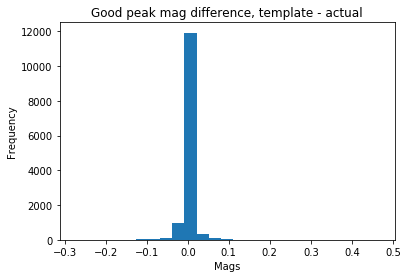

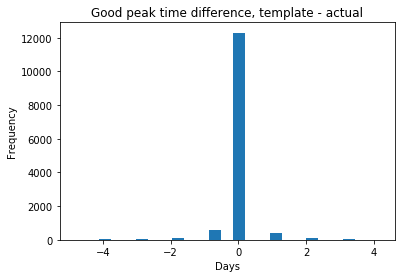

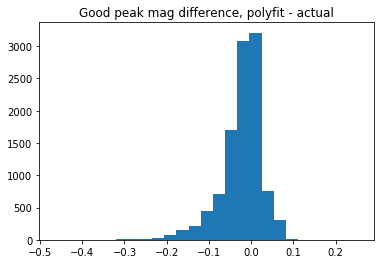

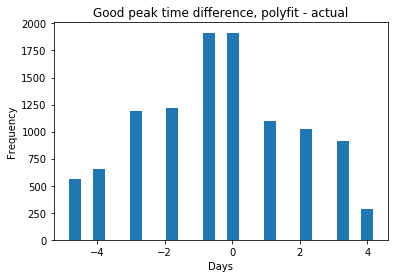

In [28]:
print detected+undetected
print peak+no_peak
for f in ['g', 'r', 'i', 'z']:
    filter_match = np.where(good_poly_diff_table['filter'] == f)
    print('average poly mag diff = %r in %s' %(np.average(good_poly_diff_table['peak_diff_mag'][filter_match]), f))
    print('average poly day diff = %r in %s' %(np.average(good_poly_diff_table['peak_diff_day'][filter_match]), f))
    
plt.figure()
plt.hist(good_template_diff_table['peak_diff_mag'], bins = 25)
plt.title('Good peak mag difference, template - actual')
plt.xlabel('Mags')
plt.ylabel('Frequency')
plt.figure()
plt.hist(good_template_diff_table['peak_diff_day'], bins = 25)
plt.title('Good peak time difference, template - actual')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.figure()
plt.hist(good_poly_diff_table['peak_diff_mag'], bins = 25)
plt.title('Good peak mag difference, polyfit - actual')
plt.figure()
plt.xlabel('Mags')
plt.ylabel('Frequency')
plt.hist(good_poly_diff_table['peak_diff_day'], bins = 25)
plt.title('Good peak time difference, polyfit - actual')
plt.xlabel('Days')
plt.ylabel('Frequency')

In [30]:
peak = 0.
no_peak = 0.
undetected = 0.
detected = 0.

for coord in range(len(bundle.metricValues)):
    opsim = opsimlist[coord]
    for testpeakmag in peakmag:
        for testpeakday in peaktime:
            shifted_tde_table = shift_peak(model, testpeakmag, testpeakday)
            opsim2 = opsim.copy()
            opsim2 = opsim2[opsim2['expMJD'] > shifted_tde_table['mjd'].min()]
            opsim2 = opsim2[opsim2['expMJD'] < shifted_tde_table['mjd'].max()]
            if len(opsim2) == 0:
                undetected += 4
            else:
                tde_lc = resample_lc(opsim2, shifted_tde_table)
                opsim2 = update_opsim(opsim2, tde_lc)
                opsim2 = find_error(opsim2)
                if len(opsim2) == 0:
                    undetected += 4
                else:
                    opsim2 = add_noise(opsim2)
                    survey = opsim2.copy()
                    survey = survey[survey['expMJD'] <= (60 + shifted_tde_table['mjd'].min())]
                    if len(np.unique(np.round(survey['expMJD']))) >= 4:
                        detected += 1
                        peak += 1
                    else:
                        undetected += 1
                        no_peak += 1

percent_peak = (peak/(peak+no_peak))*100
percent_detected = (detected/(detected+undetected))*100
print('peak ratio = %r' %percent_peak)
print('detected ratio = %r' %percent_detected)

peak ratio = 54.156094071967445
detected ratio = 37.93193935851713


In [45]:
undetected = 0.
detected = 0.

for f in ['g', 'r', 'i', 'z']:
    bad = 0.
    good = 0.
    for coord in range(len(bundle.metricValues)):
        opsim = opsimlist[coord]
        for testpeakmag in peakmag:
            for testpeakday in peaktime:
                shifted_tde_table = shift_peak(model, testpeakmag, testpeakday)
                opsim2 = opsim.copy()
                opsim2 = opsim2[opsim2['expMJD'] > shifted_tde_table['mjd'].min()]
                opsim2 = opsim2[opsim2['expMJD'] < shifted_tde_table['mjd'].max()]
                if len(opsim2) == 0:
                    undetected += 1
                else:
                    tde_lc = resample_lc(opsim2, shifted_tde_table)
                    opsim2 = update_opsim(opsim2, tde_lc)
                    opsim2 = find_error(opsim2)
                    if len(opsim2) == 0:
                        undetected += 1
                    else:
                        opsim2 = add_noise(opsim2)
                        ra = np.degrees(round(opsim2['fieldRA'][0], 5))
                        dec = np.degrees(round(opsim2['fieldDec'][0], 5))
                        survey = opsim2.copy()
                        survey = survey[survey['expMJD'] <= (60 + shifted_tde_table['mjd'].min())]
                        filter_match = np.where(survey['filter'] == f)
                        survey2 = survey[filter_match]
                        if len(np.unique(np.round(survey2['expMJD']))) >= 4:
                            good += 1
                            detected += 1
                        else:
                            bad += 1
                            undetected += 1
                            filter_per = (good/(good + bad))*100
    print(f, filter_per)

print('undetected = %r' %undetected)

('g', 0.0)
('r', 7.3262581307771315)
('i', 7.086614173228346)
('z', 7.976720301266689)
undetected = 5264.0


In [83]:
def make_template_3d(time, time_shift, mag_shift):
    new_model = model.copy()
    new_model['mjd'] += time_shift
    new_model['mag'] += mag_shift
    template = np.zeros(time.shape)
    for i,f in enumerate(['g', 'r', 'i', 'z']):
        template[i][time[i] > 0] = np.interp(time[i][time[i] > 0], new_model['mjd'][new_model['filter'] == f], 
                                             new_model['mag'][new_model['filter'] == f])
    return template

In [66]:
def resample_lc_3d(opsim, model, time_shift, mag_shift):
    new_model = model.copy()
    new_model['mjd'] += time_shift
    new_model['mag'] += mag_shift
    maxlength = np.max([sum(opsim['filter'] == f) for f in ['g', 'r', 'i', 'z']])
    resampled_mjd = np.zeros((4, maxlength))
    resampled_mag = np.zeros((4, maxlength))
    resampled_sig = np.zeros((4, maxlength)) + 1000
    for i,f in enumerate(['g', 'r', 'i', 'z']):
        filter_match = opsim['filter'] == f
        n_samples_in_filter = filter_match.sum()
        model_filter_match = new_model['filter'] == f
        mjds =  opsim['expMJD'][filter_match]
        mags = np.interp(mjds, new_model[model_filter_match]['mjd'],
                         new_model[model_filter_match]['mag'], left=99, right=99)
        # Trim off visits where the template doesn't exist
        detections = mags < 30
        mags = mags[detections]
        mjds = mjds[detections]
        five_sigma = opsim['fiveSigmaDepth'][filter_match][detections]
        
        snr = 5*(10**((-0.4)*(mags - five_sigma)))
        mag_err = 2.5/(snr*np.log(10))
        
        good_detections = mag_err < 0.3
        n_good_detections = good_detections.sum()
        resampled_mjd[i][:n_good_detections] = mjds[good_detections]
        resampled_sig[i][:n_good_detections] = mag_err[good_detections]
        resampled_mag[i][:n_good_detections] = np.random.normal(mags[good_detections], mag_err[good_detections])
    
    return resampled_mjd, resampled_mag, resampled_sig


In [94]:
mjds, mags, magerrs = resample_lc_3d(opsim, model, 60250, 20)
detections = mjds > 0
max_mjd = mjds[detections][np.argmin(mags[detections])]
max_mag = np.min(mags[detections])
'''popt2, pcov2 = curve_fit(make_template_3d, mjds, mags, 
                             p0 = [max_mjd, max_mag])#, sigma = magerrs)'''

'popt2, pcov2 = curve_fit(make_template_3d, mjds, mags, \n                             p0 = [max_mjd, max_mag])#, sigma = magerrs)'

In [95]:
def lnlike(theta, x, y, yerr):
    mjd, mag = theta
    m = make_template_3d(x, mjd, mag)
    inv_sigma2 = 1.0 /(yerr**2)
    return -0.5*(np.sum((y-m)**2*inv_sigma2 - np.log(inv_sigma2)))

In [96]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [max_mjd, max_mag], args=(mjds, mags, magerrs))

(60234.067964000002, 20.551580791390087)


      fun: 5483.828369403884
 hess_inv: array([[ 0.59071267, -0.02007316],
       [-0.02007316,  0.00069765]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 16
     njev: 20
   status: 0
  success: True
        x: array([  6.02494000e+04,   2.00180897e+01])

In [102]:
def lnprior(theta):
    mjd, mag = theta
    if 50000 < mjd < 70000 and 10.0 < mag < 30.0:
        return 0.0
    return -np.inf

In [103]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [120]:
ndim, nwalkers = 2, 16
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
print(pos)

[array([  6.02494000e+04,   2.00181038e+01]), array([  6.02494002e+04,   2.00181602e+01]), array([  6.02494001e+04,   2.00180742e+01]), array([  6.02494000e+04,   2.00181748e+01]), array([  6.02494002e+04,   2.00181311e+01]), array([  6.02494001e+04,   2.00179905e+01]), array([  6.02493999e+04,   2.00180952e+01]), array([  6.02494001e+04,   2.00179562e+01]), array([  6.02494001e+04,   2.00180719e+01]), array([  6.02494002e+04,   2.00180499e+01]), array([  6.02494001e+04,   2.00181153e+01]), array([  6.02494001e+04,   2.00180290e+01]), array([  6.02493999e+04,   2.00179176e+01]), array([  6.02493998e+04,   2.00181198e+01]), array([  6.02493999e+04,   2.00182234e+01]), array([  6.02494001e+04,   2.00180311e+01])]


In [121]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mjds, mags, magerrs))

In [129]:
sampler.run_mcmc(pos, 500)

(array([[  6.02500383e+04,   1.99955813e+01],
        [  6.02497096e+04,   1.99985008e+01],
        [  6.02504256e+04,   1.99795657e+01],
        [  6.02486810e+04,   2.00356899e+01],
        [  6.02478480e+04,   2.00640046e+01],
        [  6.02490637e+04,   2.00221613e+01],
        [  6.02500186e+04,   1.99990512e+01],
        [  6.02497462e+04,   2.00031957e+01],
        [  6.02504009e+04,   1.99802847e+01],
        [  6.02505517e+04,   1.99780626e+01],
        [  6.02497009e+04,   2.00141894e+01],
        [  6.02490937e+04,   2.00253226e+01],
        [  6.02501429e+04,   1.99997030e+01],
        [  6.02483241e+04,   2.00549218e+01],
        [  6.02507904e+04,   1.99732286e+01],
        [  6.02487640e+04,   2.00450632e+01]]),
 array([-5484.22043032, -5486.50809366, -5485.11933757, -5485.78104556,
        -5486.37066208, -5485.64687432, -5484.31095189, -5484.24809485,
        -5485.11080245, -5485.04582255, -5485.18955115, -5484.23400094,
        -5485.84483134, -5484.86745962, -5486.

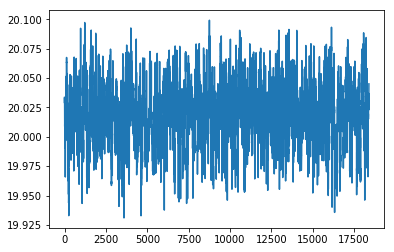

In [130]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
plt.plot(samples[:, 1])

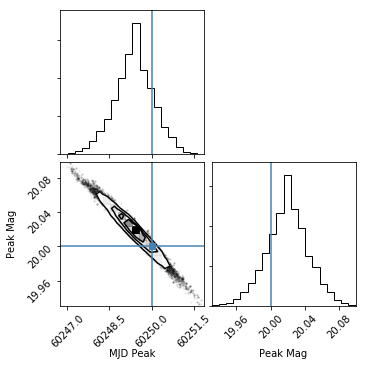

In [131]:
import corner
fig = corner.corner(samples, labels=["MJD Peak", "Peak Mag"],
                      truths=[60250, 20])
